In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [5]:
df3 = pd.read_csv('examples/IBD/IBD_functional.csv', sep=',', header=0).T
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,6137,6138,6139,6140,6141,6142,6143,6144,6145,6146
CSM5MCXR,6617.603548,3507.425103,2390.622912,2734.908297,2946.239636,2283.860715,3865.695684,1901.381967,2040.535126,4239.550969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CSM67UBB,8286.949645,3476.364698,3036.506912,3590.104056,4846.724592,2.007401,4532.403593,1373.776377,3059.645584,4372.357778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CSM67UBH,5596.495431,3169.991392,2114.664071,2313.713123,2863.321068,1855.319941,2895.521553,1873.178623,1708.843638,4474.107179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CSM67UBX,6314.228737,2833.623032,2544.651470,2245.558664,3095.795077,307.041108,4699.302824,1938.801157,2145.475796,4905.502124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CSM67UBZ,6579.152936,3280.832113,2304.628028,2468.517565,3081.908963,565.550658,3120.019455,1865.515175,2059.073892,4569.964637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# No Cross Validation Neural Net

In [22]:
    
def pre_model(df, y):
    import numpy as np
    from keras.utils import to_categorical

    # set seed for reproducibility
    np.random.seed(777)

    # shuffle the indices
    indices = np.random.permutation(len(df))

    # use the shuffled indices to shuffle the data
    df_shuffled = df[indices]
    y_shuffled = y.iloc[indices]

    # define train test split
    train_size = int(df_shuffled.shape[0] * 0.8)
    val_size = int(df_shuffled.shape[0] * 0.1)
    test_size = int(df_shuffled.shape[0] * 0.1)

    # split the shuffled data
    train_set, val_set, test_set = np.split(df_shuffled, [train_size, train_size+val_size])
    train_y, val_y, test_y = np.split(y_shuffled, [train_size, train_size+val_size])

    # transform y_train to 1 if IBD, 0 if not
    y_train = train_y.replace('IBD', 1)
    y_train = y_train.replace('Normal', 0)
    y_train = y_train.astype('int')

    # transform y_test to 1 if IBD, 0 if not
    y_test = test_y.replace('IBD', 1)
    y_test = y_test.replace('Normal', 0)
    y_test = y_test.astype('int')

    # transform y_val to 1 if IBD, 0 if not
    y_val = val_y.replace('IBD', 1)
    y_val = y_val.replace('Normal', 0)
    y_val = y_val.astype('int')

    y_train = to_categorical(y_train, num_classes=2)
    y_val = to_categorical(y_val, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    print(train_set.shape, val_set.shape, test_set.shape) # (160, 268) (20, 268) (20, 268)

    # define model
    model = Sequential()
    model.add(Dense(200, input_dim=df_shuffled.shape[1], activation='relu'))
    # add regularization layer
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # add early stopping
    from keras.callbacks import EarlyStopping
    early_stopping_monitor = EarlyStopping(patience=3)

    # fit model

    history = model.fit(train_set, y_train, validation_data=(val_set, y_val), epochs=30, batch_size=1, verbose=1, callbacks=[early_stopping_monitor])

    model.summary()

    # print accuracy
    _, train_acc = model.evaluate(train_set, y_train, verbose=0)
    _, val_acc = model.evaluate(val_set, y_val, verbose=0)
    _, test_acc = model.evaluate(test_set, y_test, verbose=0)
    print('Train: %.3f, Val: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

    y_pred_proba = model.predict(test_set)


    # plot loss and accuracy
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(20, 7))

    sns.set()

    fig.add_subplot(121)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
 
    fig.add_subplot(122)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

    from keras import Model
    # Create a new model that outputs the second to last layer's output
    second_to_last_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)

    # Extract the features of the second to last layer for both training and testing
    train_features = second_to_last_layer_model.predict(train_set)
    val_features = second_to_last_layer_model.predict(val_set)
    test_features = second_to_last_layer_model.predict(test_set)

    return train_features, val_features, test_features, y_train, y_val, y_test, y_pred_proba


## Functional Data

(160, 200) (20, 200) (20, 200)
Epoch 1/30


2023-03-05 21:45:54.307487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 1541.1660 - accuracy: 0.5188

2023-03-05 21:45:58.214071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 4s 25ms/step - loss: 1541.1660 - accuracy: 0.5188 - val_loss: 1745.1223 - val_accuracy: 0.3000
Epoch 2/30
160/160 [==============================] - 4s 23ms/step - loss: 141.9819 - accuracy: 0.5250 - val_loss: 1680.5344 - val_accuracy: 0.3000
Epoch 3/30
160/160 [==============================] - 4s 22ms/step - loss: 75.9445 - accuracy: 0.5063 - val_loss: 1584.7168 - val_accuracy: 0.3000
Epoch 4/30
160/160 [==============================] - 4s 23ms/step - loss: 23.8946 - accuracy: 0.4875 - val_loss: 1582.4186 - val_accuracy: 0.3000
Epoch 5/30
160/160 [==============================] - 4s 22ms/step - loss: 17.5052 - accuracy: 0.6062 - val_loss: 1478.7343 - val_accuracy: 0.3000
Epoch 6/30
160/160 [==============================] - 4s 22ms/step - loss: 10.0536 - accuracy: 0.6000 - val_loss: 1463.3169 - val_accuracy: 0.3000
Epoch 7/30
160/160 [==============================] - 4s 22ms/step - loss: 12.2774 - accuracy: 0.5813 - val_loss: 1441.1519 - 

2023-03-05 21:46:50.700880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.525, Val: 0.300, Test: 0.500
1/1 [==============================] - 0s 55ms/step


2023-03-05 21:46:51.026481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


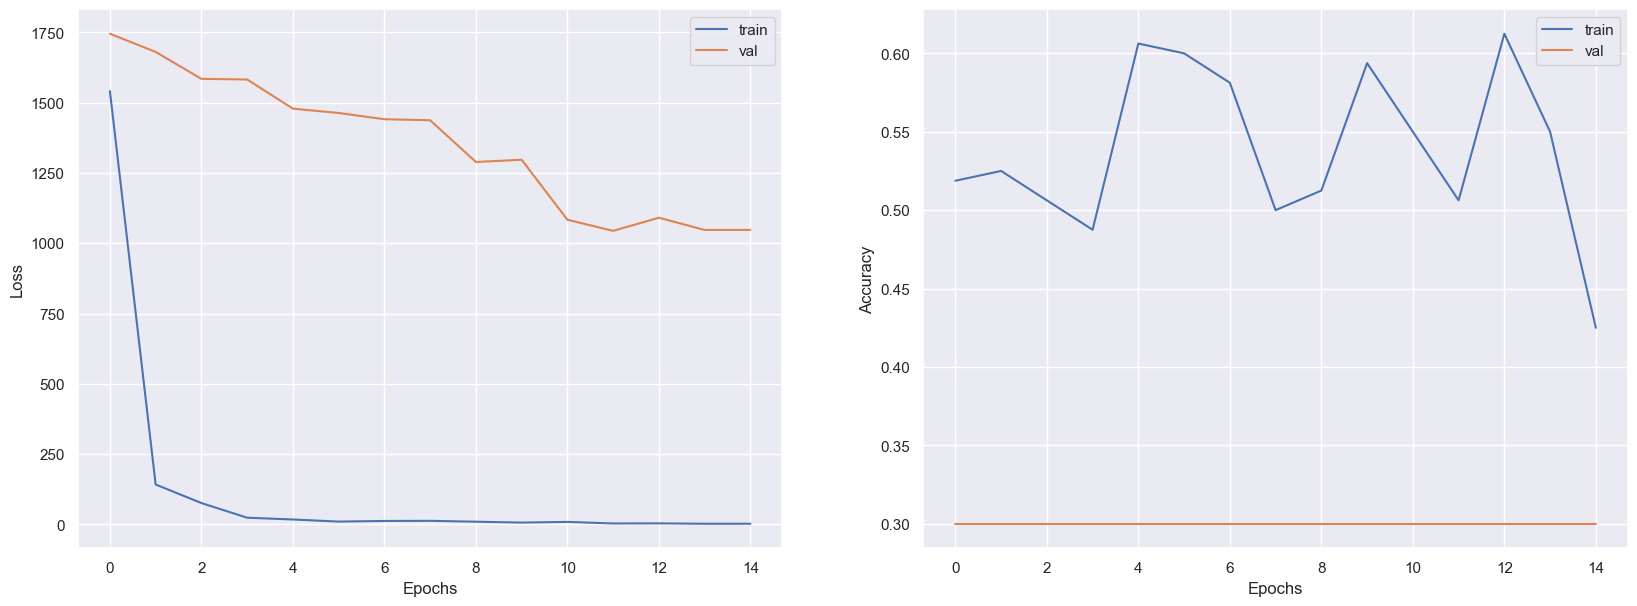

1/1 [==============================] - 0s 15ms/step


2023-03-05 21:46:51.380070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 21:46:51.462611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [23]:
set_seed = 777

# set seed for reproducibility
np.random.seed(set_seed)

df = pd.read_csv('examples/IBD/IBD_functional.csv', sep=',', header=0).T
print(df.shape)

y = pd.read_csv('examples/IBD/IBD_ylab.txt', sep='\t', header=None)

train_func, val_func, test_func, y_train, y_val, y_test, y_pred_proba_func = pre_model(df, y)

## Genomic Data

(200, 268)
(160, 200) (20, 200) (20, 200)
Epoch 1/30
  1/160 [..............................] - ETA: 1:04 - loss: 13.2208 - accuracy: 0.0000e+00

2023-03-05 21:35:30.050760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


159/160 [============================>.] - ETA: 0s - loss: 2.0334 - accuracy: 0.4717

2023-03-05 21:35:33.770575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 4s 24ms/step - loss: 2.0263 - accuracy: 0.4750 - val_loss: 1.1605 - val_accuracy: 0.3000
Epoch 2/30
160/160 [==============================] - 4s 24ms/step - loss: 1.0676 - accuracy: 0.6313 - val_loss: 1.0838 - val_accuracy: 0.3000
Epoch 3/30
160/160 [==============================] - 4s 23ms/step - loss: 0.9633 - accuracy: 0.6562 - val_loss: 1.0820 - val_accuracy: 0.3000
Epoch 4/30
160/160 [==============================] - 4s 25ms/step - loss: 0.9353 - accuracy: 0.6500 - val_loss: 1.0005 - val_accuracy: 0.4000
Epoch 5/30
160/160 [==============================] - 4s 25ms/step - loss: 0.8416 - accuracy: 0.7438 - val_loss: 1.0233 - val_accuracy: 0.3000
Epoch 6/30
160/160 [==============================] - 4s 25ms/step - loss: 0.7634 - accuracy: 0.7750 - val_loss: 1.0077 - val_accuracy: 0.3000
Epoch 7/30
160/160 [==============================] - 4s 22ms/step - loss: 0.7611 - accuracy: 0.7438 - val_loss: 0.9440 - val_accuracy: 0.5000
Epoch 8/30

2023-03-05 21:37:19.959712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.988, Val: 0.400, Test: 0.600
1/1 [==============================] - 0s 58ms/step


2023-03-05 21:37:20.294597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


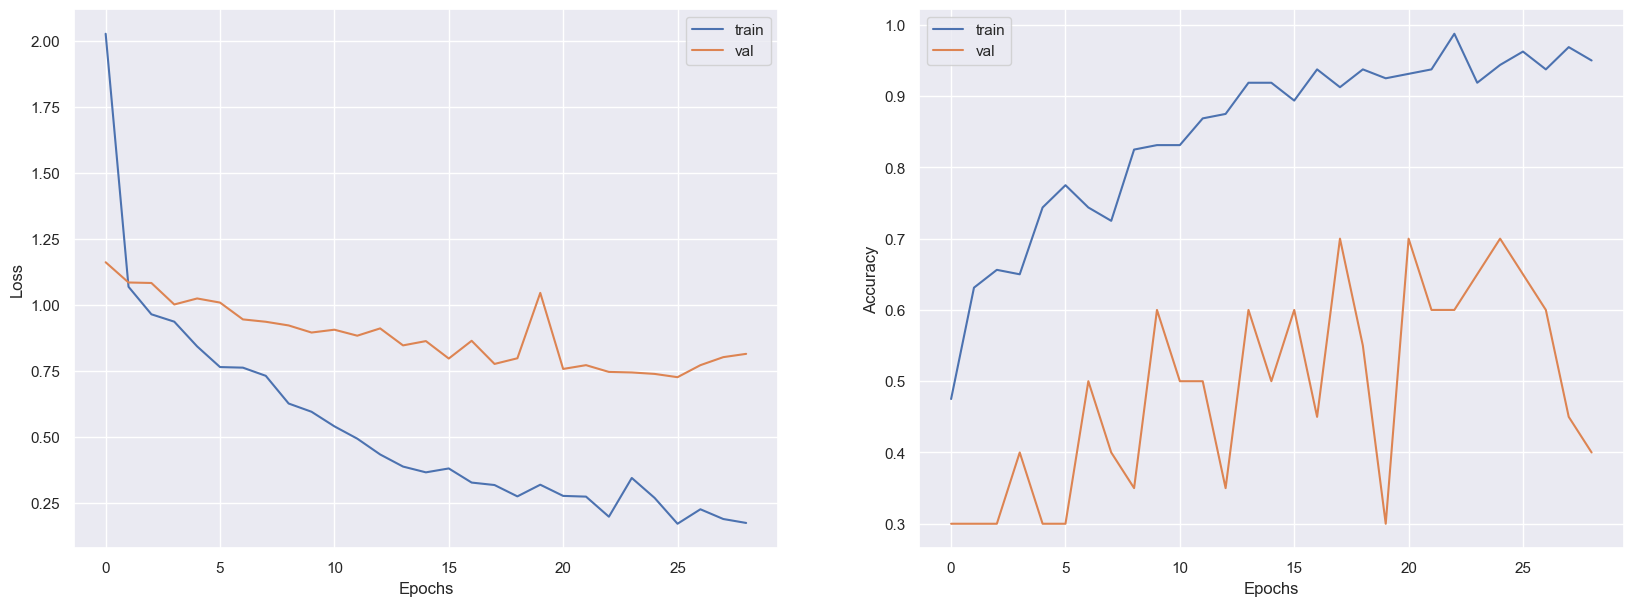

1/1 [==============================] - 0s 15ms/step


2023-03-05 21:37:20.656217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 21:37:20.758332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
np.random.seed(set_seed)

df2 = pd.read_csv('examples/IBD/IBD_genomic40.csv', sep=',', header=0).T
print(df2.shape)

train_gen, val_gen, test_gen, _, _, _, y_pred_proba_gen = pre_model(df2, y)

## Taxonomic Data

(200, 327)
(160, 200) (20, 200) (20, 200)
Epoch 1/30


2023-03-05 21:37:21.120537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 1.7630 - accuracy: 0.4688

2023-03-05 21:37:24.896978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 4s 25ms/step - loss: 1.7630 - accuracy: 0.4688 - val_loss: 1.1947 - val_accuracy: 0.7000
Epoch 2/30
160/160 [==============================] - 4s 25ms/step - loss: 1.0678 - accuracy: 0.6750 - val_loss: 1.1444 - val_accuracy: 0.1500
Epoch 3/30
160/160 [==============================] - 4s 23ms/step - loss: 0.9059 - accuracy: 0.7688 - val_loss: 1.1005 - val_accuracy: 0.2000
Epoch 4/30
160/160 [==============================] - 4s 23ms/step - loss: 0.8010 - accuracy: 0.8250 - val_loss: 1.0932 - val_accuracy: 0.3500
Epoch 5/30
160/160 [==============================] - 4s 23ms/step - loss: 0.7391 - accuracy: 0.8125 - val_loss: 1.0405 - val_accuracy: 0.3500
Epoch 6/30
160/160 [==============================] - 4s 24ms/step - loss: 0.6370 - accuracy: 0.8313 - val_loss: 0.9923 - val_accuracy: 0.4500
Epoch 7/30
160/160 [==============================] - 4s 23ms/step - loss: 0.5188 - accuracy: 0.9062 - val_loss: 1.0039 - val_accuracy: 0.3500
Epoch 8/30

2023-03-05 21:38:10.024643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.975, Val: 0.500, Test: 0.600
1/1 [==============================] - 0s 69ms/step


2023-03-05 21:38:10.348416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


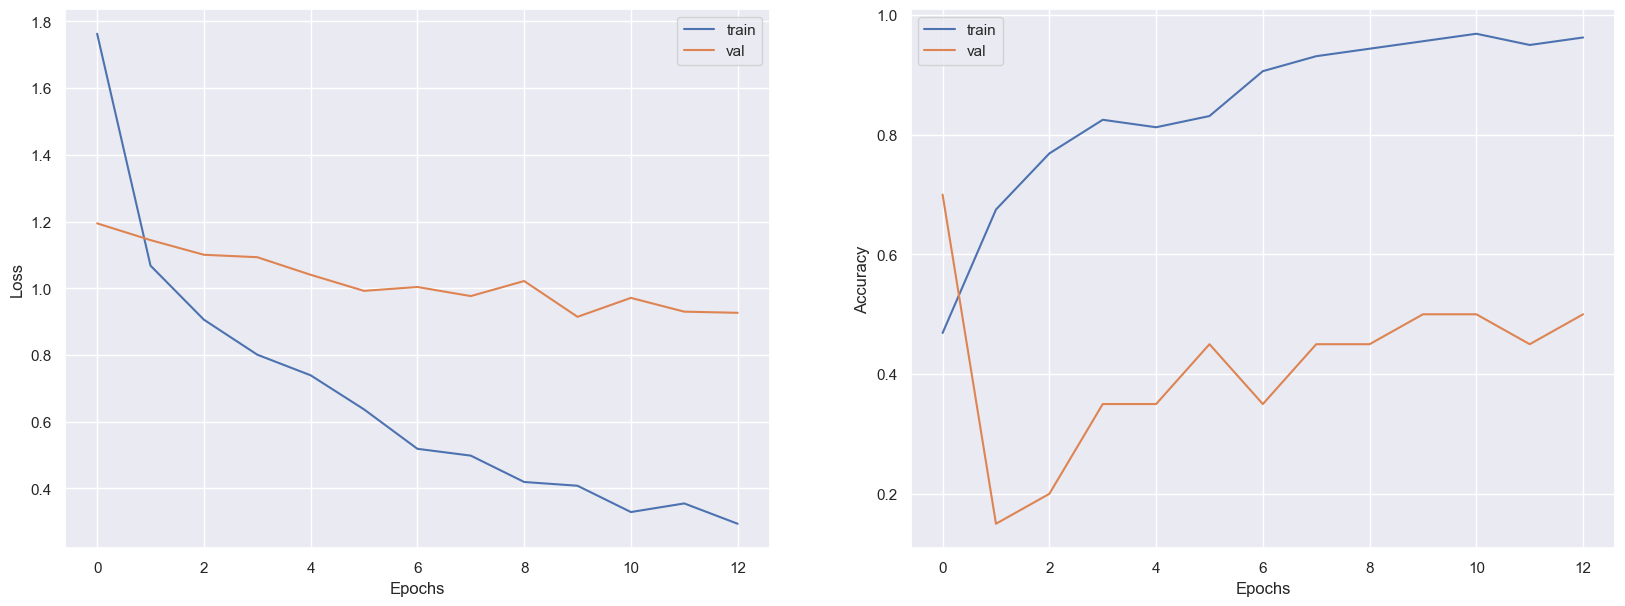

1/1 [==============================] - 0s 13ms/step


2023-03-05 21:38:10.710560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 21:38:10.793631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [13]:
np.random.seed(set_seed)

df3 = pd.read_csv('examples/IBD/IBD_taxonomic_species.csv', sep=',', header=0).T
print(df3.shape)

train_tax, val_tax, test_tax, _, _, _, y_pred_proba_tax = pre_model(df3, y)

## Combine it all 

In [15]:
# combine the features
train_features = np.concatenate((train_func, train_gen, train_tax), axis=1)
val_features = np.concatenate((val_func, val_gen, val_tax), axis=1)
test_features = np.concatenate((test_func, test_gen, test_tax), axis=1)

print(train_features.shape, val_features.shape, test_features.shape) # (160, 268) (20, 268) (20, 268)

(160, 150) (20, 150) (20, 150)


Epoch 1/10


2023-03-05 21:40:38.331326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


159/160 [============================>.] - ETA: 0s - loss: 2.9396 - accuracy: 0.4843

2023-03-05 21:40:41.789067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 4s 22ms/step - loss: 2.9242 - accuracy: 0.4875 - val_loss: 1.4792 - val_accuracy: 0.3000
Epoch 2/10
160/160 [==============================] - 3s 22ms/step - loss: 1.0101 - accuracy: 0.5688 - val_loss: 1.1450 - val_accuracy: 0.3000
Epoch 3/10
160/160 [==============================] - 3s 21ms/step - loss: 0.7755 - accuracy: 0.6750 - val_loss: 0.8775 - val_accuracy: 0.3000
Epoch 4/10
160/160 [==============================] - 3s 21ms/step - loss: 0.7632 - accuracy: 0.6313 - val_loss: 0.8725 - val_accuracy: 0.3000
Epoch 5/10
160/160 [==============================] - 3s 21ms/step - loss: 0.6158 - accuracy: 0.7750 - val_loss: 0.8212 - val_accuracy: 0.5500
Epoch 6/10
160/160 [==============================] - 3s 20ms/step - loss: 0.7577 - accuracy: 0.7063 - val_loss: 0.9182 - val_accuracy: 0.3000
Epoch 7/10
160/160 [==============================] - 3s 21ms/step - loss: 0.3975 - accuracy: 0.9187 - val_loss: 0.8630 - val_accuracy: 0.5000
Epoch 8/10

2023-03-05 21:41:12.567664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.981, Val: 0.650, Test: 0.500
1/1 [==============================] - 0s 66ms/step


2023-03-05 21:41:12.931795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


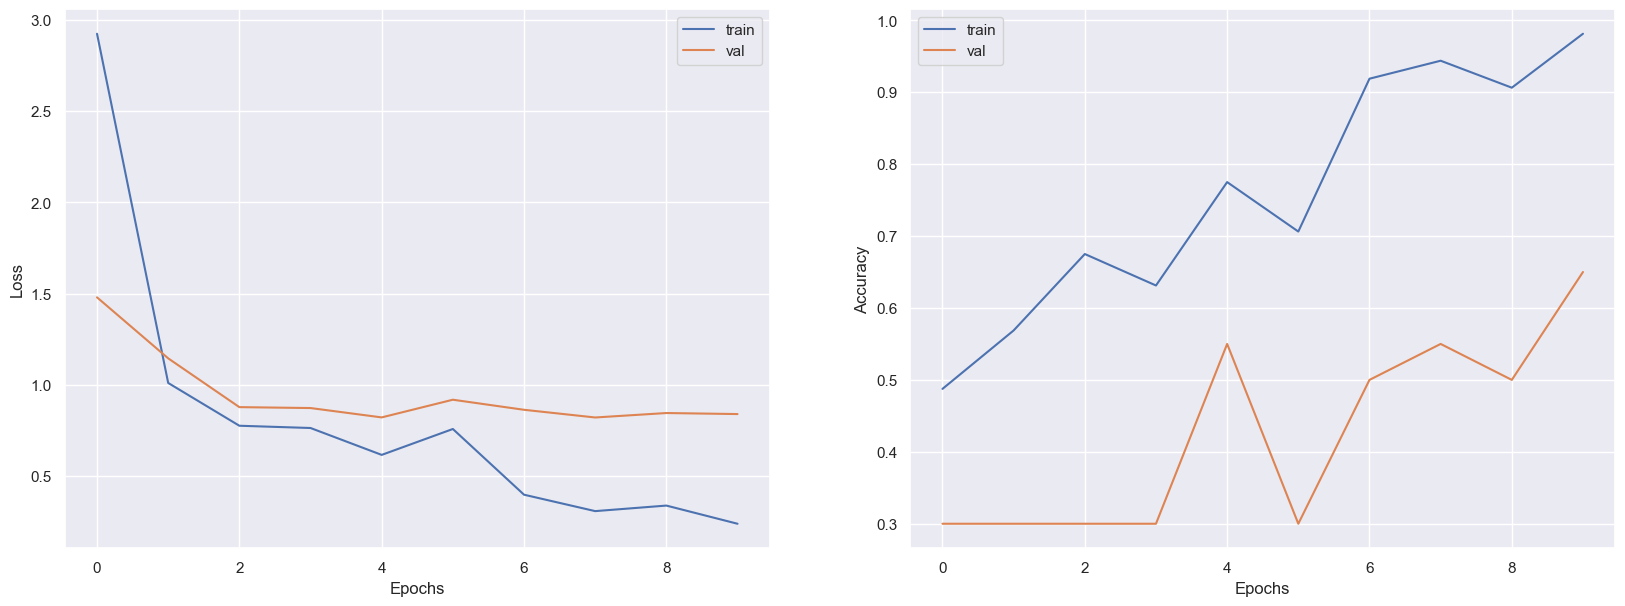

In [16]:
# define model
model = Sequential()
model.add(Dense(50, input_dim=150, activation='relu'))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# add early stopping
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)
history = model.fit(train_features, y_train, validation_data=(val_features, y_val), epochs=10, batch_size=1, verbose=1, callbacks=[early_stopping_monitor])

model.summary()

# print accuracy
_, train_acc = model.evaluate(train_features, y_train, verbose=0)
_, val_acc = model.evaluate(val_features, y_val, verbose=0)
_, test_acc = model.evaluate(test_features, y_test, verbose=0)
print('Train: %.3f, Val: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

y_pred_proba_all = model.predict(test_features)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 7))

sns.set()

fig.add_subplot(121)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# plot the roc curve for the models with the 3 y_pred_proba
from sklearn.metrics import roc_curve, auc

fpr_func, tpr_func, _ = roc_curve(y_test[:,1], y_pred_proba_func[:,1])
fpr_gen, tpr_gen, _ = roc_curve(y_test[:,1], y_pred_proba_gen[:,1])
fpr_tax, tpr_tax, _ = roc_curve(y_test[:,1], y_pred_proba_tax[:,1])
fpr_all, tpr_all, _ = roc_curve(y_test[:,1], y_pred_proba_all[:,1])

roc_auc_func = auc(fpr_func, tpr_func)
roc_auc_gen = auc(fpr_gen, tpr_gen)
roc_auc_tax = auc(fpr_tax, tpr_tax)
roc_auc_all = auc(fpr_all, tpr_all)

plt.figure(figsize=(10, 6))
plt.plot(fpr_func, tpr_func, label='Functional (area = %0.2f)' % roc_auc_func)
plt.plot(fpr_gen, tpr_gen, label='Genomic (area = %0.2f)' % roc_auc_gen)
plt.plot(fpr_tax, tpr_tax, label='Taxonomic (area = %0.2f)' % roc_auc_tax)
plt.plot(fpr_all, tpr_all, label='All (area = %0.2f)' % roc_auc_all)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## LOO Cross Validation (much much longer to run)

In [2]:
def pre_model_loocv(df, y):
    import numpy as np
    from keras.utils import to_categorical
    from sklearn.model_selection import LeaveOneOut

    # set seed for reproducibility
    np.random.seed(777)

    # shuffle the indices
    indices = np.random.permutation(len(df))

    # use the shuffled indices to shuffle the data
    df_shuffled = df.iloc[indices]
    y_shuffled = y.iloc[indices]

    # transform y to 1 if IBD, 0 if not
    y = y_shuffled.replace('IBD', 1)
    y = y.replace('Normal', 0)
    y = y.astype('int')

    # split the shuffled data
    loo = LeaveOneOut()
    train_features_list = []
    test_features_list = []
    y_train_list = []
    y_test_list = []
    y_pred_proba_list = []
    for train_idx, test_idx in loo.split(df_shuffled):
        train_set, test_set = df_shuffled.iloc[train_idx], df_shuffled.iloc[test_idx]
        train_y, test_y = y.iloc[train_idx], y.iloc[test_idx]

        # transform y_train to categorical
        y_train = to_categorical(train_y, num_classes=2)

        # transform y_test to categorical
        y_test = to_categorical(test_y, num_classes=2)

        # define model
        model = Sequential()
        model.add(Dense(200, input_dim=df_shuffled.shape[1], activation='relu'))
        # add regularization layer
        model.add(Dropout(0.5))
        model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(0.5))
        model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(0.5))
        model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # add early stopping
        from keras.callbacks import EarlyStopping
        early_stopping_monitor = EarlyStopping(patience=3)

        # fit model
        history = model.fit(train_set, y_train, validation_data=(test_set, y_test), epochs=30, batch_size=1, verbose=1, callbacks=[early_stopping_monitor])

        # print accuracy
        _, train_acc = model.evaluate(train_set, y_train, verbose=0)
        _, test_acc = model.evaluate(test_set, y_test, verbose=0)
        print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

        y_pred_proba = model.predict(test_set)

        # extract features
        from keras import Model
        second_to_last_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
        train_features = second_to_last_layer_model.predict(train_set)
        test_features = second_to_last_layer_model.predict(test_set)

        # save results
        train_features_list.append(train_features)
        test_features_list.append(test_features)
        y_train_list.append(y_train)
    return train_features_list, test_features_list, y_train_list, y_test_list, y_pred_proba_list

## Functional Data

In [3]:
# run the function
train_func, test_func, y_train, y_test, y_pred_proba = pre_model_loocv(df, y)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-05 21:56:38.821581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-05 21:56:38.821801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-05 21:56:39.035414: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2023-03-05 21:56:39.284106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1402.9816 - accuracy: 0.6181 - val_loss: 0.3788 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 1196.0779 - accuracy: 0.6667

2023-03-05 21:56:43.841169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 260.4055 - accuracy: 0.6834 - val_loss: 0.3611 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 103.8032 - accuracy: 0.7437 - val_loss: 0.3602 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 40.0915 - accuracy: 0.6935 - val_loss: 0.3599 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 2.1074 - accuracy: 0.6633 - val_loss: 0.3599 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 14.7859 - accuracy: 0.6583 - val_loss: 0.3591 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 11.6232 - accuracy: 0.6332 - val_loss: 0.3590 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 21ms/step - loss: 83.3132 - accuracy: 0.6784 - val_loss: 0.3581 - val_accuracy: 1.0000
Ep

2023-03-05 21:58:46.280186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 21:58:46.621699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 21:58:46.700371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 21:58:47.062793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 21ms/step - loss: 1191.0717 - accuracy: 0.5176 - val_loss: 18.0406 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.5900 - accuracy: 0.7500    

2023-03-05 21:58:51.409702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 167.7694 - accuracy: 0.6935 - val_loss: 5.5851 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 111.6034 - accuracy: 0.6985 - val_loss: 0.2602 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 56.3412 - accuracy: 0.4372 - val_loss: 0.9523 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 16.4771 - accuracy: 0.5678 - val_loss: 0.9444 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 46.9750 - accuracy: 0.5176 - val_loss: 0.9445 - val_accuracy: 1.0000


2023-03-05 21:59:12.774279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.518, Test: 1.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 21:59:13.086858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 21:59:13.165760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 21:59:13.529336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 991.5530 - accuracy: 0.6131 - val_loss: 0.3251 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 1577.9500 - accuracy: 0.2500    

2023-03-05 21:59:17.925817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 367.1739 - accuracy: 0.6734 - val_loss: 0.3078 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 264.1227 - accuracy: 0.7337 - val_loss: 0.3063 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 76.7498 - accuracy: 0.7236 - val_loss: 0.3057 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 2.9927 - accuracy: 0.6734 - val_loss: 0.3055 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 1.0444 - accuracy: 0.6332 - val_loss: 0.3047 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 0.8686 - accuracy: 0.7035 - val_loss: 0.3039 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 21ms/step - loss: 0.8335 - accuracy: 0.7035 - val_loss: 0.3030 - val_accuracy: 1.0000
Epoch

2023-03-05 22:01:22.340882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:01:22.647792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:01:22.728767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:01:23.403890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 720.1479 - accuracy: 0.6382 - val_loss: 0.2732 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 950.5297 - accuracy: 0.2500     

2023-03-05 22:01:27.875601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 264.0160 - accuracy: 0.6935 - val_loss: 0.2542 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 172.9187 - accuracy: 0.7186 - val_loss: 0.2537 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 139.2584 - accuracy: 0.8090 - val_loss: 0.2530 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 47.8148 - accuracy: 0.8543 - val_loss: 0.2525 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 16.7537 - accuracy: 0.9045 - val_loss: 0.2521 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 23ms/step - loss: 10.5162 - accuracy: 0.9347 - val_loss: 0.2517 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 22ms/step - loss: 14.4264 - accuracy: 0.9146 - val_loss: 0.2512 - val_accuracy: 1.0000


2023-03-05 22:02:23.670190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.925, Test: 1.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:02:23.971344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:02:24.055738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:02:24.421599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 2061.2017 - accuracy: 0.5678 - val_loss: 5188.2554 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.3446 - accuracy: 1.0000

2023-03-05 22:02:29.082435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 352.2160 - accuracy: 0.7136 - val_loss: 4752.1382 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 210.1656 - accuracy: 0.7286 - val_loss: 3575.9038 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 110.1905 - accuracy: 0.7789 - val_loss: 3380.9377 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 5s 23ms/step - loss: 74.7693 - accuracy: 0.8090 - val_loss: 3067.2119 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 5s 23ms/step - loss: 17.4065 - accuracy: 0.7136 - val_loss: 2052.9741 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 5s 23ms/step - loss: 67.0490 - accuracy: 0.7286 - val_loss: 2099.3486 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 5s 23ms/step - loss: 1.5946 - accuracy: 0.6683 -

2023-03-05 22:04:37.598828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:04:37.919258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:04:37.993835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:04:38.353071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 1318.5208 - accuracy: 0.6131 - val_loss: 4.9967 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 4s - loss: 0.2769 - accuracy: 1.0000

2023-03-05 22:04:43.231990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 396.6115 - accuracy: 0.7337 - val_loss: 6.6558 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 171.3892 - accuracy: 0.7940 - val_loss: 0.2580 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 188.1281 - accuracy: 0.7889 - val_loss: 0.2576 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 23ms/step - loss: 26.5661 - accuracy: 0.6332 - val_loss: 0.9534 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 15.3428 - accuracy: 0.6633 - val_loss: 0.9585 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 3.0664 - accuracy: 0.5427 - val_loss: 0.9553 - val_accuracy: 0.0000e+00


2023-03-05 22:05:09.664820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.568, Test: 0.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:05:09.977086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:05:10.056017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:05:10.414622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 1129.4044 - accuracy: 0.5980 - val_loss: 0.2820 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 767.0415 - accuracy: 0.5000

2023-03-05 22:05:15.313101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 279.0859 - accuracy: 0.6181 - val_loss: 0.2644 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 23ms/step - loss: 101.2375 - accuracy: 0.7186 - val_loss: 0.9257 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 23ms/step - loss: 71.4974 - accuracy: 0.6935 - val_loss: 0.8714 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 24ms/step - loss: 31.1619 - accuracy: 0.7286 - val_loss: 0.8362 - val_accuracy: 1.0000


2023-03-05 22:05:34.101271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.719, Test: 1.000
7/7 [==============================] - 0s 7ms/step


2023-03-05 22:05:34.454859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:05:34.544802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 27ms/step
Epoch 1/30


2023-03-05 22:05:34.942246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 27ms/step - loss: 978.7504 - accuracy: 0.6382 - val_loss: 8142.3745 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 4s - loss: 262.7388 - accuracy: 0.6667

2023-03-05 22:05:40.396343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 28ms/step - loss: 487.7649 - accuracy: 0.7236 - val_loss: 6907.4824 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 165.7058 - accuracy: 0.8342 - val_loss: 6675.4004 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 122.2157 - accuracy: 0.7437 - val_loss: 6687.1719 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 5s 23ms/step - loss: 55.7635 - accuracy: 0.7889 - val_loss: 6510.4731 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 5s 23ms/step - loss: 24.4707 - accuracy: 0.7940 - val_loss: 6344.5850 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 5s 24ms/step - loss: 85.2238 - accuracy: 0.4975 - val_loss: 6353.8438 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 5s 23ms/step - loss: 22.1041 - accuracy: 0.6382 

2023-03-05 22:07:50.431763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:07:50.778208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:07:50.860321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:07:51.253435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 25ms/step - loss: 1661.7386 - accuracy: 0.5879 - val_loss: 0.3889 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.3883 - accuracy: 1.0000

2023-03-05 22:07:56.375317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 252.5235 - accuracy: 0.7588 - val_loss: 0.3706 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 24ms/step - loss: 195.7177 - accuracy: 0.7889 - val_loss: 0.3694 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 23ms/step - loss: 54.5124 - accuracy: 0.8191 - val_loss: 0.3687 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 24ms/step - loss: 137.5838 - accuracy: 0.8492 - val_loss: 0.3675 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 24ms/step - loss: 60.9856 - accuracy: 0.7889 - val_loss: 0.3666 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 24ms/step - loss: 6.9172 - accuracy: 0.7638 - val_loss: 0.3659 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 24ms/step - loss: 15.9491 - accuracy: 0.6281 - val_loss: 0.3649 - val_accuracy: 1.0000
E

2023-03-05 22:10:13.148281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
7/7 [==============================] - 0s 5ms/step


2023-03-05 22:10:13.515341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:10:13.604010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 30ms/step
Epoch 1/30


2023-03-05 22:10:14.016726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 27ms/step - loss: 1105.1364 - accuracy: 0.6030 - val_loss: 361.0587 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 848.3330 - accuracy: 0.6667

2023-03-05 22:10:19.487991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 26ms/step - loss: 395.6999 - accuracy: 0.5980 - val_loss: 0.9928 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 24ms/step - loss: 96.5832 - accuracy: 0.5980 - val_loss: 0.9955 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 24ms/step - loss: 3.8484 - accuracy: 0.5678 - val_loss: 1.0051 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 5s 23ms/step - loss: 2.6482 - accuracy: 0.5427 - val_loss: 1.0065 - val_accuracy: 0.0000e+00


2023-03-05 22:10:38.802447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.553, Test: 0.000
7/7 [==============================] - 0s 6ms/step


2023-03-05 22:10:39.160494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:10:39.254240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 27ms/step
Epoch 1/30


2023-03-05 22:10:39.622917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 26ms/step - loss: 1253.7532 - accuracy: 0.6332 - val_loss: 0.2951 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 118.5793 - accuracy: 0.6667

2023-03-05 22:10:45.049834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 26ms/step - loss: 266.8179 - accuracy: 0.7487 - val_loss: 0.2765 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 26ms/step - loss: 98.7760 - accuracy: 0.8744 - val_loss: 0.2759 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 26ms/step - loss: 253.8602 - accuracy: 0.7588 - val_loss: 0.2767 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 26ms/step - loss: 68.8941 - accuracy: 0.7739 - val_loss: 0.2758 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 6s 28ms/step - loss: 58.4485 - accuracy: 0.8693 - val_loss: 0.2761 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 6s 29ms/step - loss: 39.2637 - accuracy: 0.6080 - val_loss: 0.8882 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 27ms/step - loss: 48.1756 - accuracy: 0.8141 - val_loss: 0.7828 - val_accuracy: 1.0000


2023-03-05 22:11:22.640691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.899, Test: 1.000
7/7 [==============================] - 0s 6ms/step


2023-03-05 22:11:23.025487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:11:23.115281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 31ms/step
Epoch 1/30


2023-03-05 22:11:23.492199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 28ms/step - loss: 1001.4602 - accuracy: 0.5628 - val_loss: 2205.8894 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.5629 - accuracy: 0.7500

2023-03-05 22:11:29.278045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 28ms/step - loss: 131.4777 - accuracy: 0.7638 - val_loss: 2614.4880 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 6s 29ms/step - loss: 38.8919 - accuracy: 0.7839 - val_loss: 2585.2292 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 6s 28ms/step - loss: 49.4888 - accuracy: 0.7186 - val_loss: 3352.3247 - val_accuracy: 0.0000e+00


2023-03-05 22:11:46.523479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
7/7 [==============================] - 0s 5ms/step


2023-03-05 22:11:48.333506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:11:48.452211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 24ms/step
Epoch 1/30


2023-03-05 22:11:48.858925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 25ms/step - loss: 730.6472 - accuracy: 0.6633 - val_loss: 0.2463 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.2457 - accuracy: 1.0000

2023-03-05 22:11:54.030824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 242.0189 - accuracy: 0.7286 - val_loss: 0.2278 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 23ms/step - loss: 138.0392 - accuracy: 0.7789 - val_loss: 0.2274 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 24ms/step - loss: 71.9472 - accuracy: 0.8342 - val_loss: 0.2268 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 27.2379 - accuracy: 0.8844 - val_loss: 0.2256 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 23ms/step - loss: 27.1738 - accuracy: 0.8342 - val_loss: 0.2253 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 25ms/step - loss: 6.0912 - accuracy: 0.8794 - val_loss: 0.2251 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 25ms/step - loss: 8.4821 - accuracy: 0.6533 - val_loss: 0.2249 - val_accuracy: 1.0000
Epo

2023-03-05 22:12:42.093555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.548, Test: 1.000
1/1 [==============================] - 0s 25ms/step


2023-03-05 22:12:42.454789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:12:42.540645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:12:42.950234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 28ms/step - loss: 1532.8561 - accuracy: 0.5980 - val_loss: 3201.8049 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.3819 - accuracy: 1.0000

2023-03-05 22:12:48.613521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 25ms/step - loss: 257.3875 - accuracy: 0.7789 - val_loss: 3185.5530 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 26ms/step - loss: 198.3899 - accuracy: 0.7889 - val_loss: 3644.3701 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 25ms/step - loss: 64.4590 - accuracy: 0.8442 - val_loss: 3758.9180 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 5s 25ms/step - loss: 48.2889 - accuracy: 0.7940 - val_loss: 4302.9346 - val_accuracy: 0.0000e+00


2023-03-05 22:13:09.074714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
7/7 [==============================] - 0s 7ms/step


2023-03-05 22:13:09.450428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:13:09.539325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 27ms/step
Epoch 1/30


2023-03-05 22:13:09.959217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 27ms/step - loss: 1131.4116 - accuracy: 0.6231 - val_loss: 0.3090 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 0.3085 - accuracy: 1.0000

2023-03-05 22:13:15.480280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 25ms/step - loss: 336.0396 - accuracy: 0.7487 - val_loss: 0.2898 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 26ms/step - loss: 102.3768 - accuracy: 0.8392 - val_loss: 47.3725 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 25ms/step - loss: 226.7093 - accuracy: 0.7387 - val_loss: 0.2871 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 23ms/step - loss: 161.8056 - accuracy: 0.8442 - val_loss: 0.2868 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 23ms/step - loss: 151.3206 - accuracy: 0.8744 - val_loss: 0.2855 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 24ms/step - loss: 51.4902 - accuracy: 0.8643 - val_loss: 0.2849 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 23ms/step - loss: 29.6130 - accuracy: 0.7337 - val_loss: 0.2848 - val_accuracy: 

2023-03-05 22:14:03.110221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.724, Test: 1.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:14:03.453547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:14:03.537849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:14:03.908242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 25ms/step - loss: 879.4912 - accuracy: 0.6131 - val_loss: 0.2633 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 207.0878 - accuracy: 0.6667    

2023-03-05 22:14:09.000106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 272.2524 - accuracy: 0.7136 - val_loss: 0.2429 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 24ms/step - loss: 123.6402 - accuracy: 0.8291 - val_loss: 0.2417 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 24ms/step - loss: 40.6828 - accuracy: 0.9095 - val_loss: 29.1259 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 5s 25ms/step - loss: 32.0680 - accuracy: 0.9196 - val_loss: 0.2401 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 24ms/step - loss: 40.7195 - accuracy: 0.8844 - val_loss: 0.2394 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 24ms/step - loss: 20.5901 - accuracy: 0.9196 - val_loss: 20.3717 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 5s 24ms/step - loss: 11.4700 - accuracy: 0.9146 - val_loss: 0.2383 - val_accuracy

2023-03-05 22:15:08.760517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.558, Test: 0.000
1/1 [==============================] - ETA: 0s

2023-03-05 22:15:09.157220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:15:09.246056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 29ms/step
Epoch 1/30


2023-03-05 22:15:09.655520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 27ms/step - loss: 1394.6746 - accuracy: 0.5879 - val_loss: 3796.9368 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 0.3343 - accuracy: 1.0000

2023-03-05 22:15:15.194615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 25ms/step - loss: 182.2546 - accuracy: 0.6633 - val_loss: 4323.4082 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 24ms/step - loss: 170.5655 - accuracy: 0.6583 - val_loss: 2990.7786 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 25ms/step - loss: 93.4919 - accuracy: 0.6080 - val_loss: 3135.1338 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 5s 24ms/step - loss: 45.4925 - accuracy: 0.5879 - val_loss: 3020.0718 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 5s 24ms/step - loss: 13.8723 - accuracy: 0.5578 - val_loss: 2774.3459 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 5s 24ms/step - loss: 1.4907 - accuracy: 0.5477 - val_loss: 2772.6831 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 5s 24ms/step - loss: 0.9739 - accuracy: 0.5427 - v

2023-03-05 22:17:28.365068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:17:28.681458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:17:28.757535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:17:29.090513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 21ms/step - loss: 1628.0887 - accuracy: 0.5829 - val_loss: 0.3144 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 3s - loss: 56.7833 - accuracy: 0.7500

2023-03-05 22:17:33.464395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 296.4526 - accuracy: 0.7337 - val_loss: 0.2955 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 157.8127 - accuracy: 0.8040 - val_loss: 0.2950 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 259.8999 - accuracy: 0.6683 - val_loss: 0.2949 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 20ms/step - loss: 92.9023 - accuracy: 0.7337 - val_loss: 1.0302 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 20ms/step - loss: 11.2876 - accuracy: 0.4975 - val_loss: 0.9949 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 4s 20ms/step - loss: 0.9573 - accuracy: 0.5025 - val_loss: 0.9868 - val_accuracy: 1.0000


2023-03-05 22:17:58.476958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.533, Test: 1.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:17:58.793963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:17:58.870683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:17:59.186898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1826.8500 - accuracy: 0.5678 - val_loss: 6359.6055 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 199.0517 - accuracy: 0.7500

2023-03-05 22:18:03.628275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 553.4380 - accuracy: 0.6131 - val_loss: 6114.7109 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 166.4271 - accuracy: 0.6683 - val_loss: 5381.7891 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 167.7511 - accuracy: 0.6181 - val_loss: 4692.6294 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 34.8418 - accuracy: 0.5176 - val_loss: 4635.6782 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 1.0355 - accuracy: 0.5276 - val_loss: 4618.8027 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 1.0347 - accuracy: 0.5276 - val_loss: 4599.5317 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 4s 20ms/step - loss: 1.0336 - accuracy: 0.5276 - v

2023-03-05 22:20:04.323924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 21ms/step


2023-03-05 22:20:04.660044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:20:04.734445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:20:05.060585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 2337.3269 - accuracy: 0.5879 - val_loss: 0.4051 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 1216.7844 - accuracy: 0.2500   

2023-03-05 22:20:09.640429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 232.9610 - accuracy: 0.7136 - val_loss: 0.3880 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 387.4970 - accuracy: 0.6332 - val_loss: 0.3868 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 4.6888 - accuracy: 0.6382 - val_loss: 0.3862 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 0.9414 - accuracy: 0.6382 - val_loss: 0.3857 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 0.9371 - accuracy: 0.6382 - val_loss: 0.3850 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 0.9367 - accuracy: 0.6382 - val_loss: 0.3842 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 22ms/step - loss: 0.9355 - accuracy: 0.6382 - val_loss: 0.3834 - val_accuracy: 1.0000
Epoch 

2023-03-05 22:22:15.649402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
1/1 [==============================] - 0s 22ms/step


2023-03-05 22:22:15.981893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:22:16.053049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:22:17.583685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 20ms/step - loss: 808.7139 - accuracy: 0.5930 - val_loss: 0.2781 - val_accuracy: 1.0000
Epoch 2/30
  7/199 [>.............................] - ETA: 3s - loss: 509.0073 - accuracy: 0.5714  

2023-03-05 22:22:21.681955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 19ms/step - loss: 327.0324 - accuracy: 0.7136 - val_loss: 0.2589 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 19ms/step - loss: 104.8285 - accuracy: 0.8191 - val_loss: 0.2584 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 19ms/step - loss: 55.1599 - accuracy: 0.5075 - val_loss: 0.9427 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 20ms/step - loss: 1.3656 - accuracy: 0.5528 - val_loss: 0.9372 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 20ms/step - loss: 0.8625 - accuracy: 0.5930 - val_loss: 0.9251 - val_accuracy: 1.0000


2023-03-05 22:22:41.161252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.593, Test: 1.000
1/1 [==============================] - 0s 20ms/step


2023-03-05 22:22:41.442565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:22:41.511553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/199 [..............................] - ETA: 1:08 - loss: 2.0406 - accuracy: 1.0000

2023-03-05 22:22:41.815383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 20ms/step - loss: 890.9742 - accuracy: 0.5930 - val_loss: 0.2837 - val_accuracy: 1.0000
Epoch 2/30
  7/199 [>.............................] - ETA: 3s - loss: 410.3813 - accuracy: 0.4286  

2023-03-05 22:22:45.967984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 20ms/step - loss: 236.1641 - accuracy: 0.6583 - val_loss: 0.2654 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 20ms/step - loss: 186.8245 - accuracy: 0.6784 - val_loss: 0.2657 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 20ms/step - loss: 160.3902 - accuracy: 0.7789 - val_loss: 0.2657 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 20ms/step - loss: 29.2416 - accuracy: 0.8794 - val_loss: 0.2650 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 20ms/step - loss: 61.5506 - accuracy: 0.7688 - val_loss: 0.2643 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 20ms/step - loss: 9.4800 - accuracy: 0.9196 - val_loss: 0.2637 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 20ms/step - loss: 11.9769 - accuracy: 0.8894 - val_loss: 0.2632 - val_accuracy: 1.0000
E

2023-03-05 22:23:33.361811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.940, Test: 1.000
1/1 [==============================] - 0s 21ms/step


2023-03-05 22:23:33.642839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:23:33.710885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/199 [..............................] - ETA: 1:07 - loss: 2.0361 - accuracy: 1.0000

2023-03-05 22:23:34.025399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 817.4081 - accuracy: 0.6080 - val_loss: 0.2758 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 3s - loss: 0.2752 - accuracy: 1.0000

2023-03-05 22:23:38.260096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 20ms/step - loss: 340.1206 - accuracy: 0.6884 - val_loss: 0.2572 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 20ms/step - loss: 128.2921 - accuracy: 0.6884 - val_loss: 0.2558 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 20ms/step - loss: 50.9514 - accuracy: 0.7236 - val_loss: 27.3718 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 20ms/step - loss: 32.7380 - accuracy: 0.5226 - val_loss: 0.9315 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 20ms/step - loss: 14.7161 - accuracy: 0.6181 - val_loss: 0.9090 - val_accuracy: 1.0000


2023-03-05 22:23:58.194838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.608, Test: 1.000
1/1 [==============================] - 0s 21ms/step


2023-03-05 22:23:58.478545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:23:58.544153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/199 [..............................] - ETA: 1:01 - loss: 1314.4482 - accuracy: 0.0000e+00

2023-03-05 22:23:58.848955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 1036.5592 - accuracy: 0.5628 - val_loss: 0.3029 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 310.4138 - accuracy: 0.7500

2023-03-05 22:24:03.036505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 20ms/step - loss: 213.8912 - accuracy: 0.7437 - val_loss: 0.2850 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 20ms/step - loss: 67.0707 - accuracy: 0.8191 - val_loss: 0.2841 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 20ms/step - loss: 76.8435 - accuracy: 0.8945 - val_loss: 0.2833 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 20ms/step - loss: 84.8125 - accuracy: 0.8392 - val_loss: 0.2826 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 13.7786 - accuracy: 0.8593 - val_loss: 0.2818 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 1.5124 - accuracy: 0.9497 - val_loss: 0.2810 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 21ms/step - loss: 1.4965 - accuracy: 0.9648 - val_loss: 0.2801 - val_accuracy: 1.0000
Epoc

2023-03-05 22:26:01.063642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
1/1 [==============================] - 0s 19ms/step


2023-03-05 22:26:01.362130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:26:01.429688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/199 [..............................] - ETA: 1:08 - loss: 3812.2793 - accuracy: 0.0000e+00

2023-03-05 22:26:01.750790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1155.0249 - accuracy: 0.5980 - val_loss: 0.3329 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.3323 - accuracy: 1.0000

2023-03-05 22:26:06.132310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 226.4231 - accuracy: 0.7337 - val_loss: 0.3152 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 58.6528 - accuracy: 0.8945 - val_loss: 0.3142 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 20ms/step - loss: 62.2735 - accuracy: 0.8543 - val_loss: 0.3135 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 172.7914 - accuracy: 0.7035 - val_loss: 0.3120 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 25.6073 - accuracy: 0.8442 - val_loss: 0.3112 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 13.5621 - accuracy: 0.8844 - val_loss: 0.3102 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 21ms/step - loss: 1.8136 - accuracy: 0.9447 - val_loss: 0.3095 - val_accuracy: 1.0000
Ep

2023-03-05 22:28:05.866827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
1/1 [==============================] - 0s 21ms/step


2023-03-05 22:28:06.177271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:28:06.247347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/199 [..............................] - ETA: 1:07 - loss: 2.0498 - accuracy: 1.0000

2023-03-05 22:28:06.571059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 21ms/step - loss: 771.7402 - accuracy: 0.6231 - val_loss: 0.2738 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 298.8069 - accuracy: 0.6667

2023-03-05 22:28:10.878620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 164.8215 - accuracy: 0.7387 - val_loss: 0.2548 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 95.2007 - accuracy: 0.7889 - val_loss: 3.1540 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 98.3834 - accuracy: 0.7588 - val_loss: 680.2103 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 156.0564 - accuracy: 0.7236 - val_loss: 0.9413 - val_accuracy: 1.0000


2023-03-05 22:28:27.892805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.809, Test: 1.000
1/1 [==============================] - 0s 22ms/step


2023-03-05 22:28:28.223430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:28:28.297501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:28:28.625997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 697.2579 - accuracy: 0.6080 - val_loss: 197.1117 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 459.3734 - accuracy: 0.7500     

2023-03-05 22:28:33.146458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 430.6605 - accuracy: 0.7136 - val_loss: 0.2525 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 188.3168 - accuracy: 0.8291 - val_loss: 0.2521 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 134.0145 - accuracy: 0.8291 - val_loss: 0.2521 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 53.0798 - accuracy: 0.9146 - val_loss: 0.2519 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 26.3465 - accuracy: 0.9196 - val_loss: 0.2517 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 7.3281 - accuracy: 0.9296 - val_loss: 0.2514 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 21ms/step - loss: 24.3208 - accuracy: 0.9095 - val_loss: 0.2511 - val_accuracy: 1.0000
E

2023-03-05 22:29:19.579328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.508, Test: 0.000
1/1 [==============================] - 0s 25ms/step


2023-03-05 22:29:19.918617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:29:19.992364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:29:20.299385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 864.7318 - accuracy: 0.5678 - val_loss: 5066.5107 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 655.5949 - accuracy: 0.5000     

2023-03-05 22:29:24.753610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 137.8358 - accuracy: 0.7286 - val_loss: 6373.3916 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 163.9082 - accuracy: 0.6533 - val_loss: 6133.0635 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 11.1928 - accuracy: 0.8593 - val_loss: 5866.5991 - val_accuracy: 0.0000e+00


2023-03-05 22:29:37.549333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 22ms/step


2023-03-05 22:29:37.852275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:29:37.927667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:29:38.239856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 964.2802 - accuracy: 0.5829 - val_loss: 3720.1296 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 154.6267 - accuracy: 0.5000    

2023-03-05 22:29:42.796739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 217.1125 - accuracy: 0.7035 - val_loss: 3479.6074 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 24ms/step - loss: 51.4275 - accuracy: 0.8543 - val_loss: 4181.9722 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 25ms/step - loss: 101.3931 - accuracy: 0.7990 - val_loss: 3433.5278 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 12.8069 - accuracy: 0.8995 - val_loss: 3513.9587 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 1.0174 - accuracy: 0.9648 - val_loss: 3673.3123 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 0.4606 - accuracy: 0.9899 - val_loss: 3683.7371 - val_accuracy: 0.0000e+00


2023-03-05 22:30:10.004623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 20ms/step


2023-03-05 22:30:11.612909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:30:11.683856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/199 [..............................] - ETA: 1:06 - loss: 2.0298 - accuracy: 1.0000

2023-03-05 22:30:12.013505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 20ms/step - loss: 1958.5953 - accuracy: 0.6030 - val_loss: 0.3117 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 3s - loss: 399.1880 - accuracy: 0.5000

2023-03-05 22:30:16.162676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 20ms/step - loss: 223.5428 - accuracy: 0.7588 - val_loss: 0.2937 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 20ms/step - loss: 152.5700 - accuracy: 0.7990 - val_loss: 254.6146 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 20ms/step - loss: 173.0199 - accuracy: 0.7538 - val_loss: 0.2922 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 20ms/step - loss: 127.1253 - accuracy: 0.7688 - val_loss: 0.2920 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 20ms/step - loss: 14.2451 - accuracy: 0.6784 - val_loss: 0.2920 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 20ms/step - loss: 2.0935 - accuracy: 0.5879 - val_loss: 0.2915 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 20ms/step - loss: 0.9723 - accuracy: 0.6030 - val_loss: 0.2911 - val_accuracy: 1.

2023-03-05 22:32:11.612441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.608, Test: 1.000
1/1 [==============================] - 0s 22ms/step


2023-03-05 22:32:11.916214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:32:11.993941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:32:12.316492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 692.4770 - accuracy: 0.6281 - val_loss: 0.2559 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 437.8720 - accuracy: 0.2500    

2023-03-05 22:32:16.588992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 20ms/step - loss: 180.6844 - accuracy: 0.7085 - val_loss: 42.4694 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 20ms/step - loss: 79.0220 - accuracy: 0.7638 - val_loss: 28.3328 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 20ms/step - loss: 113.9175 - accuracy: 0.7739 - val_loss: 0.2359 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 20ms/step - loss: 46.5188 - accuracy: 0.7940 - val_loss: 0.2357 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 20ms/step - loss: 61.8731 - accuracy: 0.7839 - val_loss: 0.2352 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 20ms/step - loss: 70.7939 - accuracy: 0.8442 - val_loss: 0.2346 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 20ms/step - loss: 9.0919 - accuracy: 0.9146 - val_loss: 0.2339 - val_accuracy:

2023-03-05 22:33:33.551752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.995, Test: 1.000
1/1 [==============================] - 0s 21ms/step


2023-03-05 22:33:33.858463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:33:33.928290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:33:34.252992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 21ms/step - loss: 1574.2316 - accuracy: 0.6030 - val_loss: 2668.7249 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 1089.8861 - accuracy: 0.5000   

2023-03-05 22:33:38.617390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 330.7238 - accuracy: 0.7286 - val_loss: 4425.3789 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 296.4207 - accuracy: 0.7688 - val_loss: 3603.2712 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 47.2943 - accuracy: 0.8643 - val_loss: 3469.9878 - val_accuracy: 0.0000e+00


2023-03-05 22:33:51.152625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 20ms/step


2023-03-05 22:33:51.462876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:33:51.530906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:33:51.845868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 21ms/step - loss: 1347.8821 - accuracy: 0.5879 - val_loss: 7590.4194 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 329.2375 - accuracy: 0.7500

2023-03-05 22:33:56.217811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 474.7663 - accuracy: 0.6432 - val_loss: 5978.1411 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 103.6997 - accuracy: 0.8141 - val_loss: 6013.7100 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 1.0085 - accuracy: 0.9497 - val_loss: 5930.2212 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 1.3603 - accuracy: 0.8291 - val_loss: 5951.2192 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 0.8279 - accuracy: 0.7538 - val_loss: 5942.0137 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 0.7621 - accuracy: 0.7839 - val_loss: 5937.5894 - val_accuracy: 0.0000e+00


2023-03-05 22:34:21.307344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:34:21.625602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:34:21.696528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:34:22.018094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1359.9320 - accuracy: 0.5980 - val_loss: 0.3119 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 11.0452 - accuracy: 0.7500

2023-03-05 22:34:26.543023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 85.7125 - accuracy: 0.7236 - val_loss: 0.2936 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 64.3018 - accuracy: 0.7136 - val_loss: 0.2929 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 18.2758 - accuracy: 0.8593 - val_loss: 0.2921 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 41.8207 - accuracy: 0.7638 - val_loss: 0.2916 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 5.2687 - accuracy: 0.6935 - val_loss: 0.2909 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 2.0978 - accuracy: 0.7085 - val_loss: 0.2906 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 21ms/step - loss: 1.1525 - accuracy: 0.6683 - val_loss: 0.2901 - val_accuracy: 1.0000
Epoch 

2023-03-05 22:36:28.764076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
1/1 [==============================] - 0s 22ms/step


2023-03-05 22:36:29.069195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:36:29.142655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:36:29.451285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 1328.1091 - accuracy: 0.5628 - val_loss: 0.2715 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.2624 - accuracy: 1.0000

2023-03-05 22:36:34.096479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 149.0123 - accuracy: 0.7387 - val_loss: 0.2450 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 159.4169 - accuracy: 0.7136 - val_loss: 0.2444 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 88.5839 - accuracy: 0.8392 - val_loss: 0.2445 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 306.1298 - accuracy: 0.6834 - val_loss: 1.0796 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 122.5286 - accuracy: 0.8392 - val_loss: 0.2445 - val_accuracy: 1.0000


2023-03-05 22:36:55.465923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.920, Test: 1.000
1/1 [==============================] - 0s 22ms/step


2023-03-05 22:36:55.798171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:36:55.870256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:36:56.187620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1422.6929 - accuracy: 0.5980 - val_loss: 111.7820 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 179.0121 - accuracy: 0.7500

2023-03-05 22:37:00.797800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 215.9431 - accuracy: 0.7487 - val_loss: 0.2788 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 76.0747 - accuracy: 0.7588 - val_loss: 0.2784 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 198.3677 - accuracy: 0.7186 - val_loss: 0.2791 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 23ms/step - loss: 35.9538 - accuracy: 0.8492 - val_loss: 0.2924 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 12.8313 - accuracy: 0.8693 - val_loss: 6.8441 - val_accuracy: 0.0000e+00


2023-03-05 22:37:22.774585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.834, Test: 0.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:37:23.108689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:37:23.197194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:37:23.532464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 841.6554 - accuracy: 0.5779 - val_loss: 4720.0444 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 259.3376 - accuracy: 0.7500

2023-03-05 22:37:28.231675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 141.4189 - accuracy: 0.7387 - val_loss: 4492.8618 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 139.4899 - accuracy: 0.7638 - val_loss: 4090.1895 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 194.8516 - accuracy: 0.6884 - val_loss: 3773.9841 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 68.6391 - accuracy: 0.7839 - val_loss: 3967.6018 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 26.2819 - accuracy: 0.8492 - val_loss: 4035.1125 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 34.6825 - accuracy: 0.8090 - val_loss: 4050.2786 - val_accuracy: 0.0000e+00


2023-03-05 22:37:54.017271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 30ms/step


2023-03-05 22:37:54.352045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:37:54.422513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:37:55.781175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 20ms/step - loss: 613.5850 - accuracy: 0.5628 - val_loss: 0.2299 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 3s - loss: 127.8559 - accuracy: 0.7500

2023-03-05 22:37:59.968521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 20ms/step - loss: 187.7764 - accuracy: 0.8342 - val_loss: 0.2101 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 20ms/step - loss: 370.8200 - accuracy: 0.6533 - val_loss: 0.2105 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 20ms/step - loss: 96.7232 - accuracy: 0.8040 - val_loss: 0.2102 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 20ms/step - loss: 20.8466 - accuracy: 0.8894 - val_loss: 2.8867 - val_accuracy: 0.0000e+00


2023-03-05 22:38:15.828582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.925, Test: 0.000
1/1 [==============================] - 0s 21ms/step


2023-03-05 22:38:16.114587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:38:16.183489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/199 [..............................] - ETA: 1:07 - loss: 2.0283 - accuracy: 1.0000

2023-03-05 22:38:16.480971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 21ms/step - loss: 349.2103 - accuracy: 0.5678 - val_loss: 0.2164 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.2158 - accuracy: 1.0000

2023-03-05 22:38:20.773366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 20ms/step - loss: 81.7228 - accuracy: 0.7236 - val_loss: 0.1966 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 240.8500 - accuracy: 0.7538 - val_loss: 0.1955 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 69.4576 - accuracy: 0.8593 - val_loss: 0.1951 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 18.2675 - accuracy: 0.8191 - val_loss: 0.2017 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 7.8885 - accuracy: 0.9095 - val_loss: 0.1942 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 32.2597 - accuracy: 0.8492 - val_loss: 0.1939 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 20ms/step - loss: 11.2768 - accuracy: 0.8995 - val_loss: 0.1933 - val_accuracy: 1.0000
Epo

2023-03-05 22:40:19.851349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 1.000, Test: 1.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:40:20.153438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:40:20.222998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:40:20.532695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 21ms/step - loss: 1269.1002 - accuracy: 0.5377 - val_loss: 0.2615 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 1223.1803 - accuracy: 0.7500

2023-03-05 22:40:24.855283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 376.8173 - accuracy: 0.6985 - val_loss: 0.2417 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 61.2635 - accuracy: 0.7940 - val_loss: 55.3512 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 11.7079 - accuracy: 0.9045 - val_loss: 0.2403 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 20ms/step - loss: 7.9040 - accuracy: 0.9296 - val_loss: 0.2398 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 3.9131 - accuracy: 0.9246 - val_loss: 0.2393 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 23.6700 - accuracy: 0.8241 - val_loss: 59.7598 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 4s 21ms/step - loss: 96.6057 - accuracy: 0.6231 - val_loss: 0.9604 - val_accuracy: 0

2023-03-05 22:40:58.207574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.663, Test: 0.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:40:58.518201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:40:58.595348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:40:58.913510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1141.7468 - accuracy: 0.6683 - val_loss: 0.2520 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 0.2516 - accuracy: 1.0000

2023-03-05 22:41:03.432727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 148.7871 - accuracy: 0.6734 - val_loss: 89.8487 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 68.2728 - accuracy: 0.7990 - val_loss: 15.4014 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 16.6417 - accuracy: 0.4874 - val_loss: 0.9245 - val_accuracy: 1.0000


2023-03-05 22:41:16.266900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.508, Test: 1.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:41:16.580507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:41:16.649738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:41:16.962827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1432.1666 - accuracy: 0.5779 - val_loss: 0.2685 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 61.7696 - accuracy: 0.7500     

2023-03-05 22:41:21.574066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 240.4529 - accuracy: 0.7035 - val_loss: 0.2494 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 73.4765 - accuracy: 0.8291 - val_loss: 0.2481 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 44.8119 - accuracy: 0.8844 - val_loss: 0.2480 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 99.7318 - accuracy: 0.7739 - val_loss: 13.5527 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 46.7741 - accuracy: 0.8442 - val_loss: 0.2473 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 2.8781 - accuracy: 0.6131 - val_loss: 0.2475 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 21ms/step - loss: 1.9465 - accuracy: 0.6131 - val_loss: 0.2472 - val_accuracy: 1.0000

2023-03-05 22:43:31.866582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.613, Test: 1.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:43:32.212889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:43:32.290306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:43:32.635314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 1422.4924 - accuracy: 0.5829 - val_loss: 2150.6331 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 0.4247 - accuracy: 1.0000

2023-03-05 22:43:37.630175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 402.2840 - accuracy: 0.6583 - val_loss: 3371.7412 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 24ms/step - loss: 166.1873 - accuracy: 0.5075 - val_loss: 3794.7649 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 23ms/step - loss: 5.0489 - accuracy: 0.5930 - val_loss: 3717.3013 - val_accuracy: 0.0000e+00


2023-03-05 22:43:51.967939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:43:52.327498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:43:52.405649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:43:52.756093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 851.7327 - accuracy: 0.6382 - val_loss: 0.2467 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 53.4118 - accuracy: 0.6667     

2023-03-05 22:43:57.719015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 84.3676 - accuracy: 0.7739 - val_loss: 0.2285 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 23ms/step - loss: 275.7263 - accuracy: 0.7588 - val_loss: 0.2271 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 23ms/step - loss: 52.1690 - accuracy: 0.8593 - val_loss: 0.2267 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 24ms/step - loss: 50.5675 - accuracy: 0.7136 - val_loss: 1.4571 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 60.3710 - accuracy: 0.5779 - val_loss: 0.2257 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 23ms/step - loss: 5.2531 - accuracy: 0.5528 - val_loss: 0.9525 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 5s 26ms/step - loss: 3.7508 - accuracy: 0.5226 - val_loss: 0.2255 - val_accuracy: 1.0

2023-03-05 22:44:44.148378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.528, Test: 1.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:44:44.483937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:44:44.556400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:44:44.891234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 614.8031 - accuracy: 0.6131 - val_loss: 66.7855 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 60.6238 - accuracy: 0.7500     

2023-03-05 22:44:49.503522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 162.9957 - accuracy: 0.7437 - val_loss: 149.4683 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 262.5689 - accuracy: 0.7337 - val_loss: 39.7916 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 82.0684 - accuracy: 0.7889 - val_loss: 9.1313 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 1.5004 - accuracy: 0.9095 - val_loss: 0.9946 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 0.5338 - accuracy: 0.8492 - val_loss: 1.0215 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 0.4617 - accuracy: 0.8744 - val_loss: 1.0273 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 4s 22ms/step - loss: 1.4803 - accuracy: 0.7990 - val_loss: 1.0316 -

2023-03-05 22:45:19.845843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.658, Test: 0.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:45:20.182344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:45:20.265603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:45:20.602558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 963.1999 - accuracy: 0.5779 - val_loss: 3887.3008 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 131.1128 - accuracy: 0.5000    

2023-03-05 22:45:25.241859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 515.1313 - accuracy: 0.6734 - val_loss: 2991.6233 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 133.1734 - accuracy: 0.7789 - val_loss: 4596.0850 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 166.0988 - accuracy: 0.8492 - val_loss: 5126.9199 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 52.5178 - accuracy: 0.8995 - val_loss: 5030.6909 - val_accuracy: 0.0000e+00


2023-03-05 22:45:43.022080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 25ms/step


2023-03-05 22:45:44.646495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:45:44.732610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:45:45.100643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1050.5327 - accuracy: 0.5829 - val_loss: 1546.6909 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.3927 - accuracy: 1.0000

2023-03-05 22:45:49.549816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 157.2049 - accuracy: 0.7839 - val_loss: 1342.1219 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 190.9860 - accuracy: 0.7688 - val_loss: 264.8322 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 14.5783 - accuracy: 0.9548 - val_loss: 459.4662 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 20ms/step - loss: 15.7557 - accuracy: 0.8995 - val_loss: 346.9908 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 64.3632 - accuracy: 0.9296 - val_loss: 307.6083 - val_accuracy: 0.0000e+00


2023-03-05 22:46:10.293891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:46:10.606370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:46:10.675485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/199 [..............................] - ETA: 1:07 - loss: 3358.5979 - accuracy: 0.0000e+00

2023-03-05 22:46:10.984033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1289.8535 - accuracy: 0.5829 - val_loss: 0.3564 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 997.5433 - accuracy: 0.2500     

2023-03-05 22:46:15.464352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 128.4295 - accuracy: 0.8141 - val_loss: 0.3395 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 165.4137 - accuracy: 0.7688 - val_loss: 0.3379 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 107.9342 - accuracy: 0.7940 - val_loss: 0.3371 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 90.0975 - accuracy: 0.8442 - val_loss: 0.3364 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 28.2357 - accuracy: 0.9497 - val_loss: 0.3349 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 5.2129 - accuracy: 0.9347 - val_loss: 0.3339 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 21ms/step - loss: 0.5211 - accuracy: 0.9347 - val_loss: 0.3330 - val_accuracy: 1.0000
Ep

2023-03-05 22:48:17.964250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
1/1 [==============================] - 0s 22ms/step


2023-03-05 22:48:18.272913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:48:18.346787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:48:18.666680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 1409.6924 - accuracy: 0.6281 - val_loss: 1978.0865 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 146.5095 - accuracy: 0.7500

2023-03-05 22:48:23.288004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 456.0236 - accuracy: 0.7136 - val_loss: 2399.0374 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 62.7070 - accuracy: 0.7638 - val_loss: 2717.7805 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 33.7604 - accuracy: 0.8342 - val_loss: 3135.6638 - val_accuracy: 0.0000e+00


2023-03-05 22:48:36.360204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 25ms/step


2023-03-05 22:48:36.686734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:48:36.759908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:48:37.096234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 1562.6569 - accuracy: 0.5578 - val_loss: 0.3559 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.3553 - accuracy: 1.0000

2023-03-05 22:48:41.740339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 559.6896 - accuracy: 0.6583 - val_loss: 0.3380 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 218.2870 - accuracy: 0.8342 - val_loss: 0.3371 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 99.2274 - accuracy: 0.8040 - val_loss: 0.3373 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 112.4257 - accuracy: 0.8241 - val_loss: 0.3370 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 50.1140 - accuracy: 0.8090 - val_loss: 0.3363 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 2.5286 - accuracy: 0.8442 - val_loss: 0.3359 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 22ms/step - loss: 0.9705 - accuracy: 0.7839 - val_loss: 0.3354 - val_accuracy: 1.0000
Ep

2023-03-05 22:50:47.947997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:50:48.270157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:50:48.344750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:50:48.669410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1014.3566 - accuracy: 0.5980 - val_loss: 0.3418 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 81.7120 - accuracy: 0.5000    

2023-03-05 22:50:53.256259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 132.8902 - accuracy: 0.7538 - val_loss: 0.3256 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 143.4382 - accuracy: 0.7940 - val_loss: 0.3252 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 87.1269 - accuracy: 0.8894 - val_loss: 0.3248 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 19.3386 - accuracy: 0.8794 - val_loss: 0.3245 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 42.7693 - accuracy: 0.8593 - val_loss: 0.3242 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 14.2695 - accuracy: 0.8894 - val_loss: 0.3240 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 22ms/step - loss: 77.3768 - accuracy: 0.8744 - val_loss: 0.3235 - val_accuracy: 1.0000
E

2023-03-05 22:52:59.712904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
1/1 [==============================] - ETA: 0s

2023-03-05 22:53:00.062571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:53:00.151431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 27ms/step
Epoch 1/30


2023-03-05 22:53:00.516700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 1231.8938 - accuracy: 0.6181 - val_loss: 6145.5039 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 895.7424 - accuracy: 0.5000     

2023-03-05 22:53:05.233530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 662.8427 - accuracy: 0.6281 - val_loss: 4704.3984 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 162.7475 - accuracy: 0.7035 - val_loss: 5302.4170 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 93.0975 - accuracy: 0.7839 - val_loss: 5558.7188 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 10.9377 - accuracy: 0.6533 - val_loss: 5631.7500 - val_accuracy: 0.0000e+00


2023-03-05 22:53:22.881985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:53:23.227045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:53:23.297053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:53:23.621675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 1441.7123 - accuracy: 0.6533 - val_loss: 3082.8650 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 4s - loss: 1514.7015 - accuracy: 0.6667

2023-03-05 22:53:28.432590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 395.2614 - accuracy: 0.6935 - val_loss: 1962.0408 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 23ms/step - loss: 146.0920 - accuracy: 0.8844 - val_loss: 1989.8104 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 23ms/step - loss: 44.4628 - accuracy: 0.8744 - val_loss: 2227.3013 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 83.5076 - accuracy: 0.8844 - val_loss: 2129.5833 - val_accuracy: 0.0000e+00


2023-03-05 22:53:46.677178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:53:47.019472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:53:47.099479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:53:47.420067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1469.7861 - accuracy: 0.6281 - val_loss: 99.7257 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 1086.0704 - accuracy: 0.5000

2023-03-05 22:53:52.045228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 439.2128 - accuracy: 0.7638 - val_loss: 0.3035 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 23ms/step - loss: 418.8532 - accuracy: 0.7136 - val_loss: 0.3022 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 33.6971 - accuracy: 0.8643 - val_loss: 0.3018 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 0.4188 - accuracy: 0.9397 - val_loss: 0.3014 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 0.4169 - accuracy: 0.9397 - val_loss: 0.3009 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 0.4154 - accuracy: 0.9397 - val_loss: 0.3005 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 22ms/step - loss: 0.4141 - accuracy: 0.9397 - val_loss: 0.3000 - val_accuracy: 1.0000
Epoch

2023-03-05 22:56:03.269703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.940, Test: 1.000
1/1 [==============================] - 0s 22ms/step


2023-03-05 22:56:03.612202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:56:03.684244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:56:05.326669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 23ms/step - loss: 1176.5973 - accuracy: 0.6332 - val_loss: 0.2841 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 6s - loss: 314.5435 - accuracy: 0.3333    

2023-03-05 22:56:10.016548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 127.7284 - accuracy: 0.7387 - val_loss: 0.2667 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 279.4348 - accuracy: 0.8844 - val_loss: 0.2654 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 24ms/step - loss: 76.3644 - accuracy: 0.9296 - val_loss: 0.2648 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 66.0223 - accuracy: 0.8141 - val_loss: 0.2646 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 3.3601 - accuracy: 0.7437 - val_loss: 0.5889 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 0.8380 - accuracy: 0.6533 - val_loss: 0.2864 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 22ms/step - loss: 0.7075 - accuracy: 0.8342 - val_loss: 1.1585 - val_accuracy: 0.0000e+00


2023-03-05 22:56:40.583321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.588, Test: 0.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 22:56:40.912185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:56:40.986717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:56:41.337703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 709.1157 - accuracy: 0.5779 - val_loss: 0.3091 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 284.9161 - accuracy: 0.7500

2023-03-05 22:56:45.906212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 575.1188 - accuracy: 0.6080 - val_loss: 0.2898 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 158.2391 - accuracy: 0.7839 - val_loss: 0.2884 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 64.0381 - accuracy: 0.7739 - val_loss: 0.2883 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 36.5458 - accuracy: 0.7889 - val_loss: 0.2877 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 19.0966 - accuracy: 0.8643 - val_loss: 0.2870 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 5.1007 - accuracy: 0.9095 - val_loss: 0.2866 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 22ms/step - loss: 25.7883 - accuracy: 0.9095 - val_loss: 0.2876 - val_accuracy: 1.0000
Ep

2023-03-05 22:58:17.848106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.508, Test: 0.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 22:58:18.176715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 22:58:18.250765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 22:58:18.585148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 935.2495 - accuracy: 0.5980 - val_loss: 0.2679 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 127.6122 - accuracy: 0.5000

2023-03-05 22:58:23.275730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 135.2480 - accuracy: 0.7538 - val_loss: 1.1724 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 88.0044 - accuracy: 0.8492 - val_loss: 0.2469 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 22.1392 - accuracy: 0.9146 - val_loss: 0.2463 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 41.2573 - accuracy: 0.8291 - val_loss: 5.5475 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 65.8176 - accuracy: 0.7889 - val_loss: 0.2457 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 2.9541 - accuracy: 0.9598 - val_loss: 0.2453 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 22ms/step - loss: 11.2541 - accuracy: 0.8543 - val_loss: 0.2447 - val_accuracy: 1.

2023-03-05 23:00:31.491940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 1.000, Test: 1.000
1/1 [==============================] - 0s 25ms/step


2023-03-05 23:00:31.830805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 23:00:31.907476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 23:00:32.236442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 1547.3335 - accuracy: 0.6633 - val_loss: 0.2638 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 4s - loss: 6.1993 - accuracy: 0.6667

2023-03-05 23:00:37.139228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 444.8114 - accuracy: 0.7286 - val_loss: 0.2456 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 468.6801 - accuracy: 0.7085 - val_loss: 0.2443 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 23ms/step - loss: 90.8580 - accuracy: 0.8543 - val_loss: 0.2443 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 69.6634 - accuracy: 0.8995 - val_loss: 0.2441 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 23ms/step - loss: 76.0479 - accuracy: 0.8291 - val_loss: 0.2438 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 23ms/step - loss: 25.0573 - accuracy: 0.8844 - val_loss: 0.2434 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 23ms/step - loss: 51.9367 - accuracy: 0.8693 - val_loss: 0.2428 - val_accuracy: 1.0000
E

2023-03-05 23:02:48.011367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 1.000, Test: 1.000
1/1 [==============================] - 0s 26ms/step


2023-03-05 23:02:48.372506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 23:02:48.449037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 23:02:48.783936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 25ms/step - loss: 878.8077 - accuracy: 0.5427 - val_loss: 0.2833 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 300.9258 - accuracy: 0.6667    

2023-03-05 23:02:53.949952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 126.3916 - accuracy: 0.6985 - val_loss: 0.3488 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 23ms/step - loss: 63.3418 - accuracy: 0.7236 - val_loss: 0.2649 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 23ms/step - loss: 12.2464 - accuracy: 0.8291 - val_loss: 0.2646 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 4.8922 - accuracy: 0.8643 - val_loss: 0.2664 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 23ms/step - loss: 2.6755 - accuracy: 0.9296 - val_loss: 0.2638 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 23ms/step - loss: 3.5945 - accuracy: 0.9196 - val_loss: 0.2628 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 23ms/step - loss: 1.9203 - accuracy: 0.9296 - val_loss: 0.2623 - val_accuracy: 1.0000
Epoch 

2023-03-05 23:05:07.613657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 1.000, Test: 1.000
1/1 [==============================] - 0s 26ms/step


2023-03-05 23:05:07.973925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 23:05:08.050517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 23:05:08.402074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 1001.4682 - accuracy: 0.6181 - val_loss: 71.4554 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 0.2143 - accuracy: 1.0000

2023-03-05 23:05:13.271119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 239.4167 - accuracy: 0.6231 - val_loss: 52.7087 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 26ms/step - loss: 81.8280 - accuracy: 0.7588 - val_loss: 0.1968 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 24ms/step - loss: 25.9933 - accuracy: 0.8392 - val_loss: 0.1975 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 23ms/step - loss: 106.3716 - accuracy: 0.8090 - val_loss: 0.1966 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 23ms/step - loss: 6.9013 - accuracy: 0.9196 - val_loss: 0.1988 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 23ms/step - loss: 1.8315 - accuracy: 0.9648 - val_loss: 0.1960 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 23ms/step - loss: 4.4722 - accuracy: 0.9598 - val_loss: 0.1959 - val_accuracy: 1.0000

2023-03-05 23:06:00.061256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.603, Test: 0.000
1/1 [==============================] - 0s 24ms/step


2023-03-05 23:06:00.401295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 23:06:00.475246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 23:06:00.804840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 1406.3795 - accuracy: 0.5930 - val_loss: 0.3501 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 1496.7607 - accuracy: 0.2500    

2023-03-05 23:06:05.785416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 595.6675 - accuracy: 0.7337 - val_loss: 0.3317 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 23ms/step - loss: 136.2491 - accuracy: 0.8090 - val_loss: 0.3307 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 24ms/step - loss: 12.9637 - accuracy: 0.8995 - val_loss: 0.3299 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 24ms/step - loss: 3.8085 - accuracy: 0.9497 - val_loss: 0.3292 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 23ms/step - loss: 43.2391 - accuracy: 0.9045 - val_loss: 0.3295 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 23ms/step - loss: 39.7115 - accuracy: 0.9045 - val_loss: 0.3300 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 24ms/step - loss: 116.4202 - accuracy: 0.9146 - val_loss: 0.3299 - val_accuracy: 1.0000


2023-03-05 23:06:38.778304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.492, Test: 1.000
1/1 [==============================] - 0s 25ms/step


2023-03-05 23:06:39.152320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 23:06:39.230547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 23:06:39.583843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 609.8827 - accuracy: 0.6432 - val_loss: 204.2677 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 0.2661 - accuracy: 1.0000

2023-03-05 23:06:44.396948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 366.8384 - accuracy: 0.6935 - val_loss: 15.2595 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 23ms/step - loss: 129.3615 - accuracy: 0.8191 - val_loss: 0.2456 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 23ms/step - loss: 69.3420 - accuracy: 0.8141 - val_loss: 0.2447 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 30.7912 - accuracy: 0.8442 - val_loss: 0.2439 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 2.6707 - accuracy: 0.8291 - val_loss: 0.8759 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 4s 22ms/step - loss: 0.5813 - accuracy: 0.8291 - val_loss: 0.8427 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 24ms/step - loss: 0.5840 - accuracy: 0.8191 - val_loss: 0.8158 - val_accuracy: 1.0000

2023-03-05 23:07:16.179123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.819, Test: 1.000
1/1 [==============================] - 0s 27ms/step


2023-03-05 23:07:16.535019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 23:07:16.607210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 23:07:16.949751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 26ms/step - loss: 1074.5199 - accuracy: 0.6030 - val_loss: 272.8078 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 0.3737 - accuracy: 1.0000

2023-03-05 23:07:22.375629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 24ms/step - loss: 540.0737 - accuracy: 0.6734 - val_loss: 502.4825 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 24ms/step - loss: 281.0916 - accuracy: 0.6683 - val_loss: 571.5724 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 23ms/step - loss: 92.0515 - accuracy: 0.5729 - val_loss: 726.0922 - val_accuracy: 0.0000e+00


2023-03-05 23:07:36.517940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.513, Test: 0.000
1/1 [==============================] - 0s 20ms/step


2023-03-05 23:07:38.067381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 23:07:38.145910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 23:07:38.452400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1094.5312 - accuracy: 0.6030 - val_loss: 84.3395 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 3s - loss: 0.2875 - accuracy: 1.0000

2023-03-05 23:07:43.051230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 223.8007 - accuracy: 0.7035 - val_loss: 3.8661 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 155.0363 - accuracy: 0.7739 - val_loss: 0.2736 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 64.3878 - accuracy: 0.7739 - val_loss: 30.7462 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 39.7101 - accuracy: 0.8241 - val_loss: 0.2640 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 21ms/step - loss: 11.4934 - accuracy: 0.7889 - val_loss: 1.5603 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 0.7443 - accuracy: 0.9598 - val_loss: 0.7128 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 4s 22ms/step - loss: 0.5963 - accuracy: 0.9749 - val_loss: 0.2736 - val_accurac

2023-03-05 23:08:12.647633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.975, Test: 1.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 23:08:12.952754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 23:08:13.020981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 23:08:13.319546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 21ms/step - loss: 1329.1410 - accuracy: 0.5729 - val_loss: 0.3395 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 3s - loss: 0.3389 - accuracy: 1.0000

2023-03-05 23:08:17.648048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 21ms/step - loss: 207.2626 - accuracy: 0.7236 - val_loss: 0.3228 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 20ms/step - loss: 82.6364 - accuracy: 0.8442 - val_loss: 0.3219 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 21ms/step - loss: 126.7614 - accuracy: 0.8141 - val_loss: 0.3214 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 20.0018 - accuracy: 0.9146 - val_loss: 260.9137 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 5s 25ms/step - loss: 1.3303 - accuracy: 0.9698 - val_loss: 244.3377 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 4s 21ms/step - loss: 1.4909 - accuracy: 0.6181 - val_loss: 170.7276 - val_accuracy: 0.0000e+00


2023-03-05 23:08:43.513507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.508, Test: 0.000
1/1 [==============================] - 0s 19ms/step


2023-03-05 23:08:43.815792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 23:08:43.887539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 23:08:44.185039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 23ms/step - loss: 1517.9941 - accuracy: 0.6432 - val_loss: 136.2041 - val_accuracy: 0.0000e+00
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 353.1137 - accuracy: 0.5000     

2023-03-05 23:08:48.821246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 353.4746 - accuracy: 0.6533 - val_loss: 0.3114 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 22ms/step - loss: 189.4563 - accuracy: 0.6884 - val_loss: 16.0440 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 247.5007 - accuracy: 0.7035 - val_loss: 18.2243 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 4s 21ms/step - loss: 105.8090 - accuracy: 0.8241 - val_loss: 23.3273 - val_accuracy: 0.0000e+00


2023-03-05 23:09:06.294483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.925, Test: 0.000
1/1 [==============================] - 0s 23ms/step


2023-03-05 23:09:06.639171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-05 23:09:06.708943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-05 23:09:07.017936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 22ms/step - loss: 1182.7830 - accuracy: 0.6231 - val_loss: 0.3886 - val_accuracy: 1.0000
Epoch 2/30
  4/199 [..............................] - ETA: 4s - loss: 102.5789 - accuracy: 0.7500    

2023-03-05 23:09:11.502966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 4s 22ms/step - loss: 267.9800 - accuracy: 0.7186 - val_loss: 0.3700 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 4s 21ms/step - loss: 114.8737 - accuracy: 0.7286 - val_loss: 0.3692 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 4s 22ms/step - loss: 30.6499 - accuracy: 0.7990 - val_loss: 0.3685 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 4s 22ms/step - loss: 28.7092 - accuracy: 0.8643 - val_loss: 0.3677 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 4s 22ms/step - loss: 28.0501 - accuracy: 0.8945 - val_loss: 0.3669 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 27ms/step - loss: 1.6855 - accuracy: 0.9899 - val_loss: 0.3663 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 743s 4s/step - loss: 0.3660 - accuracy: 1.0000 - val_loss: 0.3657 - val_accuracy: 1.0000
Epo

2023-03-06 01:13:16.709552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
7/7 [==============================] - 0s 6ms/step


2023-03-06 01:13:17.140251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 01:13:17.231512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 27ms/step
Epoch 1/30


2023-03-06 01:13:17.617078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 967s 5s/step - loss: 886.6928 - accuracy: 0.5879 - val_loss: 3122.2998 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 186.0645 - accuracy: 0.6667

2023-03-06 01:29:24.296081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 203s 1s/step - loss: 269.4064 - accuracy: 0.7337 - val_loss: 2064.0803 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 25ms/step - loss: 64.2979 - accuracy: 0.8794 - val_loss: 2500.7961 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 25ms/step - loss: 173.3731 - accuracy: 0.7236 - val_loss: 3859.9304 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 164s 826ms/step - loss: 209.7242 - accuracy: 0.6834 - val_loss: 2572.6111 - val_accuracy: 0.0000e+00


2023-03-06 01:35:41.226744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
7/7 [==============================] - 0s 6ms/step


2023-03-06 01:35:41.637100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 01:35:41.729024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 29ms/step
Epoch 1/30


2023-03-06 01:35:42.118016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 1054s 5s/step - loss: 2212.2065 - accuracy: 0.6382 - val_loss: 0.3550 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 4s - loss: 1488.4071 - accuracy: 0.6667

2023-03-06 01:53:15.475925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 943s 5s/step - loss: 170.3362 - accuracy: 0.7990 - val_loss: 0.3371 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 116s 588ms/step - loss: 170.5480 - accuracy: 0.8090 - val_loss: 0.3366 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 27ms/step - loss: 78.4171 - accuracy: 0.6985 - val_loss: 0.3367 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 156s 790ms/step - loss: 0.7528 - accuracy: 0.8643 - val_loss: 0.3361 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 905s 5s/step - loss: 21.9372 - accuracy: 0.9045 - val_loss: 0.3355 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 963s 5s/step - loss: 29.8614 - accuracy: 0.8241 - val_loss: 0.3349 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 949s 5s/step - loss: 5.4418 - accuracy: 0.5276 - val_loss: 95.0798 - val_accuracy: 0.0

2023-03-06 03:16:40.482749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.492, Test: 0.000
7/7 [==============================] - 0s 5ms/step


2023-03-06 03:16:40.891598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 03:16:40.996327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 29ms/step
Epoch 1/30


2023-03-06 03:16:41.392611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 86s 431ms/step - loss: 1035.5778 - accuracy: 0.5779 - val_loss: 3921.3625 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 145.1804 - accuracy: 0.6667

2023-03-06 03:18:07.021899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 1020s 5s/step - loss: 260.8452 - accuracy: 0.6482 - val_loss: 3551.0349 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 872s 4s/step - loss: 98.5897 - accuracy: 0.7538 - val_loss: 3731.2078 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 1022s 5s/step - loss: 29.5543 - accuracy: 0.8291 - val_loss: 3816.0859 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 6s 28ms/step - loss: 11.6509 - accuracy: 0.8945 - val_loss: 4020.6133 - val_accuracy: 0.0000e+00


2023-03-06 04:06:47.189450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
7/7 [==============================] - 0s 6ms/step


2023-03-06 04:24:13.081309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 04:24:13.179550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 37ms/step
Epoch 1/30


2023-03-06 04:24:13.583506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 27ms/step - loss: 1149.9271 - accuracy: 0.6181 - val_loss: 0.3207 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 2135.0947 - accuracy: 0.0000e+00

2023-03-06 04:24:19.119322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 158s 799ms/step - loss: 292.5967 - accuracy: 0.6482 - val_loss: 0.3012 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 1005s 5s/step - loss: 237.1301 - accuracy: 0.7940 - val_loss: 0.3008 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 25ms/step - loss: 128.2531 - accuracy: 0.8090 - val_loss: 0.3004 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 538s 3s/step - loss: 86.5920 - accuracy: 0.8894 - val_loss: 0.2993 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 1077s 5s/step - loss: 24.2063 - accuracy: 0.8442 - val_loss: 0.2992 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 26ms/step - loss: 88.1996 - accuracy: 0.8291 - val_loss: 0.2981 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 1046s 5s/step - loss: 8.5860 - accuracy: 0.9296 - val_loss: 0.2973 - val_accuracy: 1.

2023-03-06 07:04:18.942690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
1/1 [==============================] - 0s 26ms/step


2023-03-06 07:04:19.349961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 07:04:19.437823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-03-06 07:22:08.570817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 1075s 27ms/step - loss: 774.0573 - accuracy: 0.5528 - val_loss: 0.3330 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 6s - loss: 866.4417 - accuracy: 0.3333

2023-03-06 07:22:14.083736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 922s 5s/step - loss: 113.2544 - accuracy: 0.6784 - val_loss: 7.2095 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 161s 813ms/step - loss: 80.0868 - accuracy: 0.7337 - val_loss: 0.3141 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 1080s 5s/step - loss: 113.9028 - accuracy: 0.7186 - val_loss: 0.3140 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 420s 2s/step - loss: 53.6333 - accuracy: 0.8090 - val_loss: 0.3128 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 26ms/step - loss: 12.5557 - accuracy: 0.8844 - val_loss: 47.4654 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 212s 1s/step - loss: 3.1343 - accuracy: 0.8945 - val_loss: 60.2098 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 960s 5s/step - loss: 7.4902 - accuracy: 0.9196 - val_loss: 0.3101 - val_ac

2023-03-06 09:31:36.726219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.397, Test: 1.000
7/7 [==============================] - 0s 7ms/step


2023-03-06 09:31:37.116701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:31:37.197488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 30ms/step
Epoch 1/30


2023-03-06 09:31:37.594725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 233s 1s/step - loss: 841.0600 - accuracy: 0.5779 - val_loss: 1111.2803 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 0.3360 - accuracy: 1.0000

2023-03-06 09:35:30.138286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 9s 43ms/step - loss: 340.5395 - accuracy: 0.6784 - val_loss: 483.0000 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 25ms/step - loss: 107.8578 - accuracy: 0.7990 - val_loss: 876.0999 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 18s 91ms/step - loss: 81.8551 - accuracy: 0.8191 - val_loss: 1425.3250 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 21s 108ms/step - loss: 67.5579 - accuracy: 0.8291 - val_loss: 660.7419 - val_accuracy: 0.0000e+00


2023-03-06 09:36:23.353208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.543, Test: 0.000
7/7 [==============================] - 0s 5ms/step


2023-03-06 09:36:23.799523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:36:23.913249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 27ms/step
Epoch 1/30


2023-03-06 09:36:24.272005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 27ms/step - loss: 1332.6367 - accuracy: 0.5879 - val_loss: 0.2891 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 180.9253 - accuracy: 0.6667

2023-03-06 09:36:29.796514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 67s 337ms/step - loss: 194.4650 - accuracy: 0.6734 - val_loss: 0.2706 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 162s 820ms/step - loss: 48.1935 - accuracy: 0.7889 - val_loss: 11.5817 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 6s 29ms/step - loss: 41.5061 - accuracy: 0.8141 - val_loss: 0.2691 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 6s 29ms/step - loss: 17.3412 - accuracy: 0.8744 - val_loss: 0.2685 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 28ms/step - loss: 9.5649 - accuracy: 0.9095 - val_loss: 1028.9158 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 5s 27ms/step - loss: 25.6204 - accuracy: 0.8744 - val_loss: 0.2679 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 6s 28ms/step - loss: 179.6228 - accuracy: 0.6935 - val_loss: 269.0636 - val_

2023-03-06 09:42:53.077262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.648, Test: 1.000
7/7 [==============================] - 0s 7ms/step


2023-03-06 09:42:53.502964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:42:53.598978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 27ms/step
Epoch 1/30


2023-03-06 09:42:53.998676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 28ms/step - loss: 1330.9653 - accuracy: 0.5176 - val_loss: 0.2631 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 117.5259 - accuracy: 0.6667    

2023-03-06 09:42:59.784503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 29ms/step - loss: 99.8191 - accuracy: 0.6985 - val_loss: 0.2429 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 27ms/step - loss: 53.5760 - accuracy: 0.7638 - val_loss: 0.2418 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 27ms/step - loss: 33.9871 - accuracy: 0.7136 - val_loss: 0.2415 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 26ms/step - loss: 8.8022 - accuracy: 0.5930 - val_loss: 0.2409 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 27ms/step - loss: 1.5156 - accuracy: 0.6231 - val_loss: 0.2753 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 5s 27ms/step - loss: 0.8432 - accuracy: 0.6181 - val_loss: 0.3509 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 27ms/step - loss: 0.8408 - accuracy: 0.6231 - val_loss: 0.2898 - val_accuracy: 1.0000


2023-03-06 09:43:37.865513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.618, Test: 1.000
1/7 [===>..........................] - ETA: 0s

2023-03-06 09:43:38.300724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:43:38.423352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 29ms/step
Epoch 1/30


2023-03-06 09:43:38.828762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 28ms/step - loss: 976.5776 - accuracy: 0.6382 - val_loss: 0.2950 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 4014.2085 - accuracy: 0.0000e+00

2023-03-06 09:43:44.582653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 27ms/step - loss: 349.8772 - accuracy: 0.7085 - val_loss: 0.2761 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 27ms/step - loss: 135.9126 - accuracy: 0.7789 - val_loss: 358.8500 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 27ms/step - loss: 584.8789 - accuracy: 0.7839 - val_loss: 3.3610 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 5s 27ms/step - loss: 10.1672 - accuracy: 0.9296 - val_loss: 0.2760 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 6s 28ms/step - loss: 33.8833 - accuracy: 0.8794 - val_loss: 0.2910 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 6s 28ms/step - loss: 6.7363 - accuracy: 0.9146 - val_loss: 1.0328 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 6s 28ms/step - loss: 2.2123 - accuracy: 0.8291 - val_loss: 1.0930 - val_accur

2023-03-06 09:44:22.962896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.915, Test: 0.000
7/7 [==============================] - 0s 7ms/step


2023-03-06 09:44:23.412986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:44:23.517203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 39ms/step
Epoch 1/30


2023-03-06 09:44:23.948856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 7s 30ms/step - loss: 613.8415 - accuracy: 0.5729 - val_loss: 0.2511 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 9.6764 - accuracy: 0.6667

2023-03-06 09:44:30.209321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 30ms/step - loss: 269.5051 - accuracy: 0.6935 - val_loss: 0.2310 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 6s 30ms/step - loss: 107.7416 - accuracy: 0.7688 - val_loss: 0.2302 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 6s 29ms/step - loss: 55.7309 - accuracy: 0.8241 - val_loss: 1.6967 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 6s 29ms/step - loss: 13.5674 - accuracy: 0.8794 - val_loss: 3.7793 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 6s 29ms/step - loss: 24.4798 - accuracy: 0.9146 - val_loss: 0.6565 - val_accuracy: 1.0000


2023-03-06 09:44:59.744248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.990, Test: 1.000
7/7 [==============================] - 0s 7ms/step


2023-03-06 09:45:00.174428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:45:00.266045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 31ms/step
Epoch 1/30


2023-03-06 09:45:00.687152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 7s 32ms/step - loss: 1312.6741 - accuracy: 0.6482 - val_loss: 0.2411 - val_accuracy: 1.0000
Epoch 2/30
  1/199 [..............................] - ETA: 6s - loss: 0.2411 - accuracy: 1.0000

2023-03-06 09:45:07.323057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 31ms/step - loss: 461.1365 - accuracy: 0.7638 - val_loss: 19.7047 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 6s 31ms/step - loss: 187.4588 - accuracy: 0.7437 - val_loss: 0.2230 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 6s 31ms/step - loss: 40.0595 - accuracy: 0.8492 - val_loss: 67.8687 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 6s 30ms/step - loss: 33.5221 - accuracy: 0.8945 - val_loss: 0.2218 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 6s 29ms/step - loss: 16.4405 - accuracy: 0.9146 - val_loss: 0.2217 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 6s 28ms/step - loss: 28.7975 - accuracy: 0.8643 - val_loss: 0.2210 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 27ms/step - loss: 18.2518 - accuracy: 0.8643 - val_loss: 0.2208 - val_accuracy

2023-03-06 09:47:51.699250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 1.000, Test: 1.000
7/7 [==============================] - 0s 6ms/step


2023-03-06 09:47:52.147487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:47:52.236739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 37ms/step
Epoch 1/30


2023-03-06 09:47:52.649589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 28ms/step - loss: 1276.8793 - accuracy: 0.6181 - val_loss: 1648.4888 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 0.3769 - accuracy: 1.0000

2023-03-06 09:47:58.381981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 27ms/step - loss: 256.5786 - accuracy: 0.7387 - val_loss: 725.9521 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 5s 27ms/step - loss: 205.7542 - accuracy: 0.7337 - val_loss: 961.2219 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 5s 27ms/step - loss: 74.6088 - accuracy: 0.8492 - val_loss: 618.4572 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 5s 27ms/step - loss: 4.9488 - accuracy: 0.9548 - val_loss: 613.7873 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 5s 27ms/step - loss: 16.0229 - accuracy: 0.8844 - val_loss: 619.2823 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 5s 27ms/step - loss: 89.0676 - accuracy: 0.8392 - val_loss: 400.4007 - val_accuracy: 0.0000e+00
Epoch 8/30
199/199 [==============================] - 5s 27ms/step - loss: 0.9941 - accuracy: 0.8040 - val_los

2023-03-06 09:48:52.346105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
7/7 [==============================] - 0s 5ms/step


2023-03-06 09:48:52.779414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:48:52.862702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 28ms/step
Epoch 1/30


2023-03-06 09:48:53.234745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 30ms/step - loss: 1546.9830 - accuracy: 0.5980 - val_loss: 0.4167 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 556.7426 - accuracy: 0.6667     

2023-03-06 09:48:59.364686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 28ms/step - loss: 302.8885 - accuracy: 0.7487 - val_loss: 0.3984 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 6s 28ms/step - loss: 234.7841 - accuracy: 0.8693 - val_loss: 0.3974 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 6s 28ms/step - loss: 21.1985 - accuracy: 0.8693 - val_loss: 0.3967 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 6s 29ms/step - loss: 24.0763 - accuracy: 0.8040 - val_loss: 0.3958 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 6s 29ms/step - loss: 0.3953 - accuracy: 1.0000 - val_loss: 0.3948 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 6s 29ms/step - loss: 0.3943 - accuracy: 1.0000 - val_loss: 0.3938 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 6s 29ms/step - loss: 0.3932 - accuracy: 1.0000 - val_loss: 0.3927 - val_accuracy: 1.0000
Epoc

2023-03-06 09:51:51.354711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.497, Test: 1.000
7/7 [==============================] - 0s 5ms/step


2023-03-06 09:51:51.789015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:51:51.894884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 24ms/step
Epoch 1/30


2023-03-06 09:51:52.270821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 29ms/step - loss: 895.0755 - accuracy: 0.5980 - val_loss: 0.2602 - val_accuracy: 1.0000
Epoch 2/30
  3/199 [..............................] - ETA: 4s - loss: 742.4731 - accuracy: 0.3333     

2023-03-06 09:51:58.264212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 27ms/step - loss: 329.4689 - accuracy: 0.6985 - val_loss: 0.2412 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 28ms/step - loss: 100.2169 - accuracy: 0.8291 - val_loss: 0.2409 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 28ms/step - loss: 36.6455 - accuracy: 0.8543 - val_loss: 0.2408 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 6s 28ms/step - loss: 38.5982 - accuracy: 0.8744 - val_loss: 0.2403 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 6s 28ms/step - loss: 4.6565 - accuracy: 0.9497 - val_loss: 0.2401 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 6s 29ms/step - loss: 6.6140 - accuracy: 0.9347 - val_loss: 0.2398 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 5s 27ms/step - loss: 10.2453 - accuracy: 0.9447 - val_loss: 0.2393 - val_accuracy: 1.0000
Epo

2023-03-06 09:54:40.215806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 1.000, Test: 1.000
7/7 [==============================] - 0s 5ms/step


2023-03-06 09:54:40.654625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:54:40.749926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 33ms/step
Epoch 1/30


2023-03-06 09:54:41.133821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 29ms/step - loss: 861.3339 - accuracy: 0.5829 - val_loss: 296.3403 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 571.6209 - accuracy: 0.6667     

2023-03-06 09:54:47.212981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 28ms/step - loss: 183.5840 - accuracy: 0.7136 - val_loss: 0.2823 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 5s 27ms/step - loss: 192.5058 - accuracy: 0.8191 - val_loss: 0.2811 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 26ms/step - loss: 32.9718 - accuracy: 0.7789 - val_loss: 0.9523 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 26ms/step - loss: 0.8640 - accuracy: 0.6281 - val_loss: 0.9322 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 5s 26ms/step - loss: 0.8360 - accuracy: 0.6633 - val_loss: 0.9114 - val_accuracy: 1.0000


2023-03-06 09:55:13.962335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.764, Test: 1.000
7/7 [==============================] - 0s 6ms/step


2023-03-06 09:55:14.379257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:55:14.486696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 29ms/step
Epoch 1/30


2023-03-06 09:55:14.860248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 29ms/step - loss: 1100.4727 - accuracy: 0.6482 - val_loss: 303.1292 - val_accuracy: 0.0000e+00
Epoch 2/30
  1/199 [..............................] - ETA: 6s - loss: 0.2898 - accuracy: 1.0000

2023-03-06 09:55:20.919900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 28ms/step - loss: 234.1414 - accuracy: 0.6734 - val_loss: 99.9072 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 6s 29ms/step - loss: 109.4593 - accuracy: 0.8241 - val_loss: 0.2722 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 5s 27ms/step - loss: 78.6604 - accuracy: 0.6834 - val_loss: 0.8646 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 5s 27ms/step - loss: 83.0415 - accuracy: 0.6985 - val_loss: 0.8538 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 6s 28ms/step - loss: 19.0914 - accuracy: 0.5930 - val_loss: 0.9338 - val_accuracy: 1.0000


2023-03-06 09:55:48.880595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.724, Test: 1.000
7/7 [==============================] - 0s 7ms/step


2023-03-06 09:55:49.316652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:55:49.411010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 30ms/step
Epoch 1/30


2023-03-06 09:55:49.809857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 29ms/step - loss: 1023.2846 - accuracy: 0.5930 - val_loss: 59.9188 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 467.7527 - accuracy: 0.3333    

2023-03-06 09:55:55.753143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 5s 28ms/step - loss: 359.6397 - accuracy: 0.7236 - val_loss: 0.2737 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 6s 28ms/step - loss: 48.0748 - accuracy: 0.7638 - val_loss: 0.2728 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 6s 29ms/step - loss: 14.3895 - accuracy: 0.8844 - val_loss: 0.2721 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 6s 29ms/step - loss: 24.0773 - accuracy: 0.8291 - val_loss: 0.2716 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 6s 29ms/step - loss: 30.7382 - accuracy: 0.8643 - val_loss: 5.5423 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 6s 28ms/step - loss: 8.1440 - accuracy: 0.7889 - val_loss: 0.3057 - val_accuracy: 1.0000
Epoch 8/30
199/199 [==============================] - 6s 28ms/step - loss: 11.0849 - accuracy: 0.8342 - val_loss: 0.2698 - val_accuracy: 1.0000

2023-03-06 09:57:20.706256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.613, Test: 0.000
7/7 [==============================] - 0s 8ms/step


2023-03-06 09:57:21.154632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:57:21.248046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 31ms/step
Epoch 1/30


2023-03-06 09:57:21.659494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 7s 32ms/step - loss: 812.5349 - accuracy: 0.5729 - val_loss: 10.7623 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 314.0365 - accuracy: 0.3333    

2023-03-06 09:57:28.362995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 30ms/step - loss: 151.8773 - accuracy: 0.6533 - val_loss: 0.2360 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 6s 30ms/step - loss: 88.2730 - accuracy: 0.7889 - val_loss: 0.2352 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 6s 29ms/step - loss: 28.4264 - accuracy: 0.8392 - val_loss: 0.2350 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 6s 31ms/step - loss: 7.3864 - accuracy: 0.8794 - val_loss: 0.9182 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 6s 32ms/step - loss: 0.5614 - accuracy: 0.8543 - val_loss: 0.3055 - val_accuracy: 1.0000
Epoch 7/30
199/199 [==============================] - 6s 30ms/step - loss: 0.4060 - accuracy: 0.9849 - val_loss: 0.3008 - val_accuracy: 1.0000


2023-03-06 09:58:04.744917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.985, Test: 1.000
7/7 [==============================] - 0s 8ms/step


2023-03-06 09:58:05.219425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:58:05.326757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 33ms/step
Epoch 1/30


2023-03-06 09:58:05.797663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 7s 34ms/step - loss: 1412.6532 - accuracy: 0.5427 - val_loss: 2552.0723 - val_accuracy: 0.0000e+00
Epoch 2/30
  1/199 [..............................] - ETA: 6s - loss: 0.3506 - accuracy: 1.0000

2023-03-06 09:58:12.829043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 30ms/step - loss: 335.0459 - accuracy: 0.7387 - val_loss: 2067.2842 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 6s 31ms/step - loss: 105.7788 - accuracy: 0.7739 - val_loss: 2481.6460 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 7s 33ms/step - loss: 67.0660 - accuracy: 0.8141 - val_loss: 1805.5194 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 6s 31ms/step - loss: 10.4153 - accuracy: 0.9296 - val_loss: 1977.0432 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 6s 30ms/step - loss: 12.5124 - accuracy: 0.9397 - val_loss: 1976.1974 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 6s 31ms/step - loss: 39.7075 - accuracy: 0.8995 - val_loss: 2129.5264 - val_accuracy: 0.0000e+00


2023-03-06 09:58:50.120937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
7/7 [==============================] - 0s 8ms/step


2023-03-06 09:58:50.603293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:58:50.706427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 35ms/step
Epoch 1/30


2023-03-06 09:58:51.130902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 7s 34ms/step - loss: 2010.4177 - accuracy: 0.5930 - val_loss: 0.3068 - val_accuracy: 1.0000
Epoch 2/30
  1/199 [..............................] - ETA: 6s - loss: 1900.9860 - accuracy: 0.0000e+00

2023-03-06 09:58:58.170638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 32ms/step - loss: 298.7585 - accuracy: 0.7337 - val_loss: 119.3012 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 7s 34ms/step - loss: 269.2989 - accuracy: 0.7789 - val_loss: 937.9984 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 6s 32ms/step - loss: 303.5019 - accuracy: 0.8090 - val_loss: 829.2958 - val_accuracy: 0.0000e+00


2023-03-06 09:59:17.880646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
7/7 [==============================] - 0s 8ms/step


2023-03-06 09:59:18.366692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 09:59:18.472639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 30ms/step
Epoch 1/30


2023-03-06 09:59:18.908697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 7s 32ms/step - loss: 967.5563 - accuracy: 0.6131 - val_loss: 5167.6279 - val_accuracy: 0.0000e+00
Epoch 2/30
  1/199 [..............................] - ETA: 6s - loss: 0.3281 - accuracy: 1.0000

2023-03-06 09:59:25.345102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 32ms/step - loss: 498.3464 - accuracy: 0.7136 - val_loss: 5032.9512 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 6s 29ms/step - loss: 156.3986 - accuracy: 0.7940 - val_loss: 3809.8005 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 6s 31ms/step - loss: 80.7102 - accuracy: 0.7638 - val_loss: 2733.3154 - val_accuracy: 0.0000e+00
Epoch 5/30
199/199 [==============================] - 6s 30ms/step - loss: 89.2941 - accuracy: 0.5226 - val_loss: 2770.5452 - val_accuracy: 0.0000e+00
Epoch 6/30
199/199 [==============================] - 6s 32ms/step - loss: 9.2682 - accuracy: 0.6231 - val_loss: 2784.9729 - val_accuracy: 0.0000e+00
Epoch 7/30
199/199 [==============================] - 7s 34ms/step - loss: 3.0300 - accuracy: 0.6382 - val_loss: 2786.9363 - val_accuracy: 0.0000e+00


2023-03-06 10:00:03.020230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
7/7 [==============================] - 0s 7ms/step


2023-03-06 10:00:03.572572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 10:00:03.675989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 31ms/step
Epoch 1/30


2023-03-06 10:00:04.127082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 9s 41ms/step - loss: 1634.0356 - accuracy: 0.6030 - val_loss: 0.3171 - val_accuracy: 1.0000
Epoch 2/30
  1/199 [..............................] - ETA: 7s - loss: 0.3171 - accuracy: 1.0000

2023-03-06 10:00:12.455029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 31ms/step - loss: 187.2361 - accuracy: 0.7789 - val_loss: 0.2993 - val_accuracy: 1.0000
Epoch 3/30
199/199 [==============================] - 6s 31ms/step - loss: 146.7705 - accuracy: 0.7688 - val_loss: 0.2988 - val_accuracy: 1.0000
Epoch 4/30
199/199 [==============================] - 6s 29ms/step - loss: 65.2247 - accuracy: 0.6080 - val_loss: 0.4724 - val_accuracy: 1.0000
Epoch 5/30
199/199 [==============================] - 6s 28ms/step - loss: 1.9269 - accuracy: 0.5628 - val_loss: 0.4636 - val_accuracy: 1.0000
Epoch 6/30
199/199 [==============================] - 6s 29ms/step - loss: 0.9418 - accuracy: 0.5678 - val_loss: 0.4660 - val_accuracy: 1.0000


2023-03-06 10:00:42.021718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.568, Test: 1.000
7/7 [==============================] - 0s 6ms/step


2023-03-06 10:00:42.438981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 10:00:42.529501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 30ms/step
Epoch 1/30


2023-03-06 10:00:42.922328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 30ms/step - loss: 1937.1909 - accuracy: 0.5678 - val_loss: 2193.4478 - val_accuracy: 0.0000e+00
Epoch 2/30
  3/199 [..............................] - ETA: 5s - loss: 4627.0762 - accuracy: 0.0000e+00 

2023-03-06 10:00:48.964428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 28ms/step - loss: 394.2944 - accuracy: 0.6985 - val_loss: 3068.2292 - val_accuracy: 0.0000e+00
Epoch 3/30
199/199 [==============================] - 6s 29ms/step - loss: 285.5199 - accuracy: 0.6935 - val_loss: 3274.9519 - val_accuracy: 0.0000e+00
Epoch 4/30
199/199 [==============================] - 6s 30ms/step - loss: 76.4314 - accuracy: 0.8442 - val_loss: 3254.4592 - val_accuracy: 0.0000e+00


2023-03-06 10:01:06.408300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Train: 0.503, Test: 0.000
7/7 [==============================] - 0s 6ms/step


2023-03-06 10:01:06.829696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 10:01:06.925918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 27ms/step
Epoch 1/30


2023-03-06 10:01:07.308314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 7s 32ms/step - loss: 1500.9402 - accuracy: 0.5930 - val_loss: 0.2592 - val_accuracy: 1.0000
Epoch 2/30
  1/199 [..............................] - ETA: 7s - loss: 941.5739 - accuracy: 0.0000e+00

2023-03-06 10:01:13.838405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


199/199 [==============================] - 6s 31ms/step - loss: 346.6527 - accuracy: 0.7136 - val_loss: 0.2410 - val_accuracy: 1.0000
Epoch 3/30
 77/199 [==========>...................] - ETA: 3s - loss: 173.0831 - accuracy: 0.6753

In [ ]:
# plot the roc curve for the models with the 3 y_pred_proba
from sklearn.metrics import roc_curve, auc

fpr_func, tpr_func, _ = roc_curve(y_test[:,1], y_pred_proba[:,1])

roc_auc_func = auc(fpr_func, tpr_func)

plt.figure(figsize=(10, 6))
plt.plot(fpr_func, tpr_func, label='Functional (area = %0.2f)' % roc_auc_func)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Genomic Data

In [ ]:
np.random.seed(set_seed)

df2 = pd.read_csv('examples/IBD/IBD_genomic40.csv', sep=',', header=0).T
print(df2.shape)

train_gen, test_gen, _, _, y_pred_proba_gen = pre_model(df2, y)

## Taxonomic Data

In [ ]:
np.random.seed(set_seed)

df3 = pd.read_csv('examples/IBD/IBD_taxonomic_species.csv', sep=',', header=0).T
print(df3.shape)

train_tax, test_tax, _, _, y_pred_proba_tax = pre_model(df3, y)

## Combine All

In [ ]:
# combine the features
train_features = np.concatenate((train_func, train_gen, train_tax), axis=1)
test_features = np.concatenate((test_func, test_gen, test_tax), axis=1)

print(train_features.shape, test_features.shape) # (160, 268) (20, 268) (20, 268)

In [ ]:
# define model
model = Sequential()
model.add(Dense(50, input_dim=150, activation='relu'))
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# add early stopping
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)
history = model.fit(train_features, y_train, validation_data=(test_features, y_test), epochs=10, batch_size=1, verbose=1, callbacks=[early_stopping_monitor])

model.summary()

# print accuracy
_, train_acc = model.evaluate(train_features, y_train, verbose=0)
_, test_acc = model.evaluate(test_features, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

y_pred_proba_all = model.predict(test_features)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 7))

sns.set()

fig.add_subplot(121)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# plot the roc curve for the models with the 3 y_pred_proba
from sklearn.metrics import roc_curve, auc

fpr_func, tpr_func, _ = roc_curve(y_test[:,1], y_pred_proba_func[:,1])
fpr_gen, tpr_gen, _ = roc_curve(y_test[:,1], y_pred_proba_gen[:,1])
fpr_tax, tpr_tax, _ = roc_curve(y_test[:,1], y_pred_proba_tax[:,1])
fpr_all, tpr_all, _ = roc_curve(y_test[:,1], y_pred_proba_all[:,1])

roc_auc_func = auc(fpr_func, tpr_func)
roc_auc_gen = auc(fpr_gen, tpr_gen)
roc_auc_tax = auc(fpr_tax, tpr_tax)
roc_auc_all = auc(fpr_all, tpr_all)

plt.figure(figsize=(10, 6))
plt.plot(fpr_func, tpr_func, label='Functional (area = %0.2f)' % roc_auc_func)
plt.plot(fpr_gen, tpr_gen, label='Genomic (area = %0.2f)' % roc_auc_gen)
plt.plot(fpr_tax, tpr_tax, label='Taxonomic (area = %0.2f)' % roc_auc_tax)
plt.plot(fpr_all, tpr_all, label='All (area = %0.2f)' % roc_auc_all)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()